In [1]:
library(tidyverse)
library(readxl)
library(cowplot)
library(dndscv)
library(GenomicRanges)
library(readr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.7
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Warning message:
“replacing previous import ‘Biostrings::translate’ by ‘seqinr::translate’ when loading ‘dndscv’”Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are m

## 1 Oesophagus data

In this notebook, I'll use [dndsv](https://github.com/im3sanger/dndscv) to recalculate $dN/dS$ ratios from data in the paper [Somatic mutant clones colonize the human esophagus with age](https://www.ncbi.nlm.nih.gov/pubmed/30337457). 

I'll calculate $dN/dS$ across the frequency range by fixing a lower bound and increasing the upper bound step by step. This interval $dN/dS$ can then be used in our model framework to infer parameters related to the clonal dynamics.

In [2]:
#read in donor info data
dfdonor <- read_xlsx("data/esophagus/patient_info.xlsx", skip = 1) %>%
  dplyr::rename(patient = PD)

#read in mutation data
df <- read_csv("data/esophagus/esophagus.csv") %>%
  mutate(sumvaf = sumvaf * 2)

target_genes <- unique(df$gene)

Parsed with column specification:
cols(
  donor = col_character(),
  chr = col_character(),
  pos = col_integer(),
  ref = col_character(),
  mut = col_character(),
  sumvaf = col_double(),
  qval = col_double(),
  gene = col_character(),
  impact = col_character(),
  aachange = col_character(),
  ntchange = col_character(),
  pid = col_character(),
  merged = col_character()
)


First I'll calculate interval $dN/dS$ ratios across the whole cohort

In [5]:
minarea <- 0.02
maxarea <- 2.5
step <- 0.05
areacutoff <- seq(minarea, maxarea, step)
target_genes <- unique(df$gene)

dfdnds <- data.frame()
dfdnds.genes <- data.frame()

for (cutoff in areacutoff){
  print(cutoff)
  x1 <- df %>%
    filter(sumvaf < cutoff) #filter for mutations with sumvaf < cutoff
  x <- dndscv(x1, gene_list = target_genes,
              outp = 3, max_muts_per_gene_per_sample = Inf, 
              max_coding_muts_per_sample = Inf)
  out <- x$globaldnds %>%
    mutate(areacutoff = cutoff, nmutations = length(x1$donor))
  dfdnds <- rbind(dfdnds, out)
  combined <- left_join(x$sel_cv, x$sel_loc, 
                        by = c("gene_name", "n_syn", "n_mis", "n_non", "n_spl"))
  out2 <- combined %>%
    mutate(areacutoff = cutoff)
  dfdnds.genes <- rbind(dfdnds.genes, out2)
  print(x$globaldnds)
}

[1] 0.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 10.9).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3.”    Regression model for indels (theta = 2.97)


     name      mle    cilow   cihigh
wmis wmis 1.470944 1.287522 1.680495
wnon wnon 3.978046 3.224557 4.907605
wspl wspl 3.418671 2.580541 4.529017
wtru wtru 3.784218 3.148648 4.548081
wall wall 1.669137 1.464509 1.902357
[1] 0.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.86).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, AJUBA, CCND1.”    Regression model for indels (theta = 4.78)


     name      mle    cilow   cihigh
wmis wmis 1.724943 1.563642 1.902883
wnon wnon 5.859105 5.094970 6.737844
wspl wspl 5.860288 4.864851 7.059409
wtru wtru 5.859472 5.169253 6.641851
wall wall 2.071186 1.881189 2.280372
[1] 0.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.57).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, AJUBA, CCND1, PIK3CA, KMT2D.”    Regression model for indels (theta = 4.66)


     name      mle    cilow   cihigh
wmis wmis 1.852630 1.685677 2.036119
wnon wnon 6.443111 5.645040 7.354011
wspl wspl 6.769507 5.691989 8.051004
wtru wtru 6.543533 5.810112 7.369535
wall wall 2.242892 2.044555 2.460470
[1] 0.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.2).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, AJUBA, CCND1, PIK3CA, KMT2D, ARID2.”    Regression model for indels (theta = 4.74)


     name      mle    cilow   cihigh
wmis wmis 1.920141 1.750292 2.106472
wnon wnon 6.724158 5.910632 7.649656
wspl wspl 6.986024 5.902058 8.269071
wtru wtru 6.805169 6.059304 7.642844
wall wall 2.326564 2.124555 2.547780
[1] 0.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.19).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, AJUBA, CCND1, PIK3CA, KMT2D, ARID2.”    Regression model for indels (theta = 4.65)


     name      mle    cilow   cihigh
wmis wmis 1.950722 1.779748 2.138122
wnon wnon 6.969177 6.138675 7.912038
wspl wspl 7.299769 6.184953 8.615526
wtru wtru 7.070867 6.306481 7.927903
wall wall 2.375490 2.171131 2.599085
[1] 0.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.07).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, AJUBA, CCND1, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.77)


     name      mle    cilow   cihigh
wmis wmis 1.980246 1.807662 2.169307
wnon wnon 7.188643 6.339596 8.151401
wspl wspl 7.475561 6.344012 8.808938
wtru wtru 7.276991 6.496596 8.151130
wall wall 2.417547 2.210722 2.643722
[1] 0.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.89).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, AJUBA, CCND1, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.79)


     name      mle    cilow   cihigh
wmis wmis 1.997570 1.824068 2.187576
wnon wnon 7.277655 6.422615 8.246527
wspl wspl 7.682506 6.530405 9.037863
wtru wtru 7.402240 6.612627 8.286141
wall wall 2.441639 2.233445 2.669240
[1] 0.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.95).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, AJUBA, CCND1, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.79)


     name      mle    cilow   cihigh
wmis wmis 1.989693 1.817667 2.177999
wnon wnon 7.247570 6.399603 8.207895
wspl wspl 7.843459 6.677138 9.213507
wtru wtru 7.430433 6.641713 8.312816
wall wall 2.434917 2.228273 2.660725
[1] 0.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.92).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, AJUBA, CCND1, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.79)


     name      mle    cilow   cihigh
wmis wmis 2.000184 1.827648 2.189008
wnon wnon 7.358684 6.500705 8.329901
wspl wspl 7.823266 6.662373 9.186441
wtru wtru 7.501932 6.707996 8.389836
wall wall 2.449897 2.242443 2.676544
[1] 0.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.8).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, AJUBA, CCND1, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 5.04)


     name      mle    cilow   cihigh
wmis wmis 2.001923 1.829527 2.190564
wnon wnon 7.364752 6.507644 8.334749
wspl wspl 7.828501 6.668836 9.189823
wtru wtru 7.507682 6.714490 8.394575
wall wall 2.451663 2.244400 2.678065
[1] 0.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.79).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, AJUBA, CCND1, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 5.04)


     name      mle    cilow   cihigh
wmis wmis 2.011465 1.838328 2.200909
wnon wnon 7.390940 6.531460 8.363519
wspl wspl 7.917895 6.747945 9.290690
wtru wtru 7.553247 6.755954 8.444631
wall wall 2.463103 2.254953 2.690467
[1] 0.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.87).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 5.04)


     name      mle    cilow   cihigh
wmis wmis 2.016654 1.843247 2.206375
wnon wnon 7.412854 6.552361 8.386353
wspl wspl 7.981515 6.804351 9.362330
wtru wtru 7.587490 6.787735 8.481475
wall wall 2.470311 2.261764 2.698088
[1] 0.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.86).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.93)


     name      mle    cilow   cihigh
wmis wmis 2.025190 1.851121 2.215627
wnon wnon 7.469794 6.603778 8.449380
wspl wspl 8.066201 6.879389 9.457759
wtru wtru 7.653010 6.847323 8.553497
wall wall 2.482816 2.273298 2.711645
[1] 0.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.86).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.93)


     name      mle    cilow   cihigh
wmis wmis 2.031141 1.856615 2.222074
wnon wnon 7.534698 6.662115 8.521570
wspl wspl 8.112558 6.920043 9.510578
wtru wtru 7.712311 6.901082 8.618899
wall wall 2.492317 2.282061 2.721944
[1] 0.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.93)


     name      mle    cilow   cihigh
wmis wmis 2.033936 1.859203 2.225090
wnon wnon 7.573929 6.697464 8.565093
wspl wspl 8.122699 6.928745 9.522395
wtru wtru 7.742602 6.928570 8.652274
wall wall 2.496818 2.286219 2.726816
[1] 0.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.93)


     name      mle    cilow   cihigh
wmis wmis 2.039941 1.864742 2.231601
wnon wnon 7.616570 6.735786 8.612526
wspl wspl 8.143514 6.946532 9.546752
wtru wtru 7.778491 6.961044 8.691932
wall wall 2.504891 2.293664 2.735569
[1] 0.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.93)


     name      mle    cilow   cihigh
wmis wmis 2.040805 1.865539 2.232538
wnon wnon 7.674456 6.788006 8.676667
wspl wspl 8.176608 6.975767 9.584168
wtru wtru 7.828818 7.006795 8.747280
wall wall 2.509610 2.298010 2.740694
[1] 0.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.93)


     name      mle    cilow   cihigh
wmis wmis 2.044145 1.868624 2.236154
wnon wnon 7.669658 6.783875 8.671099
wspl wspl 8.185597 6.983480 9.594644
wtru wtru 7.828091 7.006198 8.746400
wall wall 2.512487 2.300671 2.743805
[1] 0.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.93)


     name      mle    cilow   cihigh
wmis wmis 2.048971 1.873067 2.241394
wnon wnon 7.692220 6.804035 8.696347
wspl wspl 8.220902 7.014503 9.634785
wtru wtru 7.854599 7.030120 8.775771
wall wall 2.518469 2.306181 2.750298
[1] 0.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.93)


     name      mle    cilow   cihigh
wmis wmis 2.051828 1.875698 2.244496
wnon wnon 7.709471 6.819504 8.715581
wspl wspl 8.229048 7.021511 9.644253
wtru wtru 7.869067 7.043200 8.791772
wall wall 2.522138 2.309562 2.754280
[1] 1.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.93)


     name      mle    cilow   cihigh
wmis wmis 2.053500 1.877240 2.246308
wnon wnon 7.728295 6.836335 8.736633
wspl wspl 8.238693 7.030913 9.653947
wtru wtru 7.885355 7.057983 8.809716
wall wall 2.524557 2.311791 2.756905
[1] 1.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.93)


     name      mle    cilow   cihigh
wmis wmis 2.054429 1.878103 2.247309
wnon wnon 7.735039 6.842539 8.743952
wspl wspl 8.241097 7.033000 9.656716
wtru wtru 7.890706 7.062902 8.815533
wall wall 2.525718 2.312866 2.758160
[1] 1.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.93)


     name      mle    cilow   cihigh
wmis wmis 2.054698 1.878354 2.247597
wnon wnon 7.758942 6.864081 8.770463
wspl wspl 8.243051 7.034686 9.658980
wtru wtru 7.907892 7.078523 8.834436
wall wall 2.527396 2.314412 2.759979
[1] 1.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.93)


     name      mle    cilow   cihigh
wmis wmis 2.055736 1.879313 2.248722
wnon wnon 7.788629 6.890766 8.803482
wspl wspl 8.240360 7.032599 9.655538
wtru wtru 7.927773 7.096617 8.856274
wall wall 2.529944 2.316761 2.762743
[1] 1.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.93)


     name      mle    cilow   cihigh
wmis wmis 2.058279 1.881660 2.251476
wnon wnon 7.801833 6.902836 8.817912
wspl wspl 8.269760 7.058955 9.688251
wtru wtru 7.945971 7.113246 8.876180
wall wall 2.533627 2.320163 2.766731
[1] 1.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.93)


     name      mle    cilow   cihigh
wmis wmis 2.058821 1.882163 2.252060
wnon wnon 7.810835 6.910981 8.827856
wspl wspl 8.271775 7.060688 9.690594
wtru wtru 7.952811 7.119474 8.883691
wall wall 2.534615 2.321076 2.767799
[1] 1.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.93)


     name      mle    cilow   cihigh
wmis wmis 2.058821 1.882163 2.252060
wnon wnon 7.810835 6.910981 8.827856
wspl wspl 8.271775 7.060688 9.690594
wtru wtru 7.952811 7.119474 8.883691
wall wall 2.534615 2.321076 2.767799
[1] 1.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.058821 1.882163 2.252060
wnon wnon 7.810835 6.910981 8.827856
wspl wspl 8.271775 7.060688 9.690594
wtru wtru 7.952811 7.119474 8.883691
wall wall 2.534615 2.321076 2.767799
[1] 1.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.059223 1.882535 2.252494
wnon wnon 7.812074 6.912075 8.829259
wspl wspl 8.273130 7.061847 9.692178
wtru wtru 7.954087 7.120615 8.885117
wall wall 2.535008 2.321440 2.768224
[1] 1.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.059223 1.882535 2.252494
wnon wnon 7.812074 6.912075 8.829259
wspl wspl 8.273130 7.061847 9.692178
wtru wtru 7.954087 7.120615 8.885117
wall wall 2.535008 2.321440 2.768224
[1] 1.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.059912 1.883170 2.253243
wnon wnon 7.801929 6.903173 8.817698
wspl wspl 8.274626 7.063124 9.693931
wtru wtru 7.947398 7.114658 8.877607
wall wall 2.535346 2.321753 2.768589
[1] 1.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.061365 1.884504 2.254825
wnon wnon 7.815206 6.915140 8.832422
wspl wspl 8.280076 7.067771 9.700323
wtru wtru 7.958246 7.124495 8.889568
wall wall 2.537629 2.323854 2.771071
[1] 1.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.062875 1.885897 2.256461
wnon wnon 7.819852 6.919236 8.837694
wspl wspl 8.284948 7.071938 9.706018
wtru wtru 7.962970 7.128713 8.894858
wall wall 2.539132 2.325240 2.772698
[1] 1.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.062875 1.885897 2.256461
wnon wnon 7.819852 6.919236 8.837694
wspl wspl 8.284948 7.071938 9.706018
wtru wtru 7.962970 7.128713 8.894858
wall wall 2.539132 2.325240 2.772698
[1] 1.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.063432 1.886412 2.257063
wnon wnon 7.821562 6.920745 8.839632
wspl wspl 8.286634 7.073385 9.707983
wtru wtru 7.964676 7.130240 8.896766
wall wall 2.539680 2.325747 2.773291
[1] 1.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.063432 1.886412 2.257063
wnon wnon 7.821562 6.920745 8.839632
wspl wspl 8.286634 7.073385 9.707983
wtru wtru 7.964676 7.130240 8.896766
wall wall 2.539680 2.325747 2.773291
[1] 1.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.063432 1.886412 2.257063
wnon wnon 7.821562 6.920745 8.839632
wspl wspl 8.286634 7.073385 9.707983
wtru wtru 7.964676 7.130240 8.896766
wall wall 2.539680 2.325747 2.773291
[1] 1.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.063432 1.886412 2.257063
wnon wnon 7.821562 6.920745 8.839632
wspl wspl 8.286634 7.073385 9.707983
wtru wtru 7.964676 7.130240 8.896766
wall wall 2.539680 2.325747 2.773291
[1] 1.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.065160 1.888007 2.258935
wnon wnon 7.810498 6.911106 8.826934
wspl wspl 8.286543 7.073432 9.707705
wtru wtru 7.956861 7.123334 8.887921
wall wall 2.540885 2.326862 2.774593
[1] 1.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.066547 1.889286 2.260439
wnon wnon 7.809582 6.910369 8.825805
wspl wspl 8.290874 7.077129 9.712779
wtru wtru 7.957481 7.123922 8.888574
wall wall 2.542120 2.328003 2.775931
[1] 2.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.066716 1.889443 2.260622
wnon wnon 7.811057 6.911666 8.827483
wspl wspl 8.320870 7.103777 9.746488
wtru wtru 7.967751 7.133243 8.899887
wall wall 2.542876 2.328700 2.776750
[1] 2.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.067081 1.889781 2.261016
wnon wnon 7.812045 6.912539 8.828600
wspl wspl 8.317943 7.101380 9.742920
wtru wtru 7.967597 7.133125 8.899691
wall wall 2.543198 2.328998 2.777097
[1] 2.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.066896 1.889612 2.260814
wnon wnon 7.812067 6.912557 8.828628
wspl wspl 8.335556 7.117272 9.762378
wtru wtru 7.973100 7.138156 8.905705
wall wall 2.543331 2.329122 2.777240
[1] 2.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.067122 1.889820 2.261058
wnon wnon 7.827195 6.926158 8.845450
wspl wspl 8.337313 7.118771 9.764437
wtru wtru 7.984146 7.148175 8.917883
wall wall 2.544352 2.330062 2.778349
[1] 2.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.070508 1.892940 2.264733
wnon wnon 7.837604 6.935324 8.857268
wspl wspl 8.348102 7.128002 9.777047
wtru wtru 7.994692 7.157585 8.929703
wall wall 2.547742 2.333188 2.782027
[1] 2.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.070508 1.892940 2.264733
wnon wnon 7.837604 6.935324 8.857268
wspl wspl 8.348102 7.128002 9.777047
wtru wtru 7.994692 7.157585 8.929703
wall wall 2.547742 2.333188 2.782027
[1] 2.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.84).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.070508 1.892940 2.264733
wnon wnon 7.837604 6.935324 8.857268
wspl wspl 8.348102 7.128002 9.777047
wtru wtru 7.994692 7.157585 8.929703
wall wall 2.547742 2.333188 2.782027
[1] 2.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.88).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.067494 1.890298 2.261302
wnon wnon 7.822770 6.922619 8.839968
wspl wspl 8.336897 7.118675 9.763593
wtru wtru 7.980883 7.145629 8.913769
wall wall 2.544025 2.329926 2.777799
[1] 2.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.88).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.067759 1.890543 2.261587
wnon wnon 7.823581 6.923336 8.840886
wspl wspl 8.337674 7.119345 9.764495
wtru wtru 7.981686 7.146350 8.914665
wall wall 2.544282 2.330164 2.778076
[1] 2.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.88).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, CUL3, CCND1, AJUBA, PIK3CA, ARID2, KMT2D.”    Regression model for indels (theta = 4.91)


     name      mle    cilow   cihigh
wmis wmis 2.068378 1.891113 2.262258
wnon wnon 7.813586 6.914561 8.829500
wspl wspl 8.338719 7.120243 9.765710
wtru wtru 7.974949 7.140345 8.907107
wall wall 2.544508 2.330373 2.778319


In [63]:
#write results to file
write_csv(dfdnds, "data/esophagus/dnds_combined.csv")
write_csv(dfdnds.genes, "data/esophagus/dnds_genes_combined.csv")

Now I'll calculate interval $dN/dS$ on a donor by donor basis

In [64]:
dfdnds.patient <- data.frame()
dfdnds.genes.patient <- data.frame()
i <- 1
for (p in unique(df$donor)){
  print(p)
  print(i)
  for (cutoff in areacutoff){
    print(cutoff)
    x1 <- df %>%
      filter(donor == p) %>%
      filter(sumvaf < cutoff) #filter for mutations with sumvaf < cutoff
    x <- dndscv(x1, gene_list = target_genes,
                outp = 3, max_muts_per_gene_per_sample = Inf, 
                max_coding_muts_per_sample = Inf)
    out <- x$globaldnds %>%
        mutate(areacutoff = cutoff, nmutations = length(x1$donor), patient = p)
    dfdnds.patient <- rbind(dfdnds.patient, out)
    combined <- left_join(x$sel_cv, x$sel_loc, by = c("gene_name", "n_syn", "n_mis", "n_non", "n_spl"))
    out2 <- combined %>%
      mutate(areacutoff = cutoff, patient = p)
    dfdnds.genes.patient <- rbind(dfdnds.genes.patient, out2)
    print(x$globaldnds)
  }
  i + i +1
}

[1] "PD36806"
[1] 1
[1] 0.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.24).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1.”    Regression model for indels (theta = 3.31)


     name      mle     cilow    cihigh
wmis wmis 1.050626 0.5329708  2.071060
wnon wnon 2.847422 0.9424148  8.603231
wspl wspl 4.838163 1.4991419 15.614149
wtru wtru 3.578295 1.4530270  8.812082
wall wall 1.262727 0.6514573  2.447558
[1] 0.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.563).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle     cilow    cihigh
wmis wmis 1.338241 0.8164619  2.193475
wnon wnon 5.355054 2.6608848 10.777095
wspl wspl 7.563687 3.2734387 17.476837
wtru wtru 6.060694 3.2815445 11.193511
wall wall 1.694659 1.0454558  2.747003
[1] 0.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.668).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle     cilow    cihigh
wmis wmis 1.507182 0.9322923  2.436572
wnon wnon 5.748858 2.9325995 11.269650
wspl wspl 7.657939 3.3622418 17.441942
wtru wtru 6.348732 3.5017275 11.510433
wall wall 1.887950 1.1801753  3.020192
[1] 0.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.662).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.573016 0.975853  2.535608
wnon wnon 5.929997 3.056273 11.505803
wspl wspl 7.900075 3.471137 17.980042
wtru wtru 6.529371 3.620603 11.775025
wall wall 1.965717 1.231517  3.137629
[1] 0.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.656).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.645237 1.022620  2.646931
wnon wnon 6.560050 3.424889 12.565154
wspl wspl 8.204425 3.605878 18.667458
wtru wtru 7.053481 3.937503 12.635317
wall wall 2.078577 1.304583  3.311771
[1] 0.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 0.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 0.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 0.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 0.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 0.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 0.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 0.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 0.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 0.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 0.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 0.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 0.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 0.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 0.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.657).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3.”    Regression model for indels (theta = 5.74)


     name      mle    cilow    cihigh
wmis wmis 1.687212 1.049912  2.711356
wnon wnon 6.554195 3.428977 12.527781
wspl wspl 8.353603 3.672122 19.003368
wtru wtru 7.085544 3.960087 12.677734
wall wall 2.120286 1.331941  3.375233
[1] 1.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.658).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3, TP53.”    Regression model for indels (theta = 5.45)


     name      mle    cilow    cihigh
wmis wmis 1.700159 1.058431  2.730966
wnon wnon 6.471969 3.391553 12.350206
wspl wspl 8.393351 3.689909 19.092159
wtru wtru 7.031213 3.933145 12.569575
wall wall 2.129808 1.338325  3.389373
[1] 2.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.658).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3, TP53.”    Regression model for indels (theta = 5.45)


     name      mle    cilow    cihigh
wmis wmis 1.700159 1.058431  2.730966
wnon wnon 6.471969 3.391553 12.350206
wspl wspl 8.393351 3.689909 19.092159
wtru wtru 7.031213 3.933145 12.569575
wall wall 2.129808 1.338325  3.389373
[1] 2.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.658).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3, TP53.”    Regression model for indels (theta = 5.45)


     name      mle    cilow    cihigh
wmis wmis 1.700159 1.058431  2.730966
wnon wnon 6.471969 3.391553 12.350206
wspl wspl 8.393351 3.689909 19.092159
wtru wtru 7.031213 3.933145 12.569575
wall wall 2.129808 1.338325  3.389373
[1] 2.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.658).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3, TP53.”    Regression model for indels (theta = 5.45)


     name      mle    cilow    cihigh
wmis wmis 1.700159 1.058431  2.730966
wnon wnon 6.471969 3.391553 12.350206
wspl wspl 8.393351 3.689909 19.092159
wtru wtru 7.031213 3.933145 12.569575
wall wall 2.129808 1.338325  3.389373
[1] 2.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.658).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3, TP53.”    Regression model for indels (theta = 5.45)


     name      mle    cilow    cihigh
wmis wmis 1.700159 1.058431  2.730966
wnon wnon 6.471969 3.391553 12.350206
wspl wspl 8.393351 3.689909 19.092159
wtru wtru 7.031213 3.933145 12.569575
wall wall 2.129808 1.338325  3.389373
[1] 2.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.658).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3, TP53.”    Regression model for indels (theta = 5.45)


     name      mle    cilow    cihigh
wmis wmis 1.700159 1.058431  2.730966
wnon wnon 6.471969 3.391553 12.350206
wspl wspl 8.393351 3.689909 19.092159
wtru wtru 7.031213 3.933145 12.569575
wall wall 2.129808 1.338325  3.389373
[1] 2.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.658).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3, TP53.”    Regression model for indels (theta = 5.45)


     name      mle    cilow    cihigh
wmis wmis 1.700159 1.058431  2.730966
wnon wnon 6.471969 3.391553 12.350206
wspl wspl 8.393351 3.689909 19.092159
wtru wtru 7.031213 3.933145 12.569575
wall wall 2.129808 1.338325  3.389373
[1] 2.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.658).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3, TP53.”    Regression model for indels (theta = 5.45)


     name      mle    cilow    cihigh
wmis wmis 1.700159 1.058431  2.730966
wnon wnon 6.471969 3.391553 12.350206
wspl wspl 8.393351 3.689909 19.092159
wtru wtru 7.031213 3.933145 12.569575
wall wall 2.129808 1.338325  3.389373
[1] 2.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.658).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3, TP53.”    Regression model for indels (theta = 5.45)


     name      mle    cilow    cihigh
wmis wmis 1.700159 1.058431  2.730966
wnon wnon 6.471969 3.391553 12.350206
wspl wspl 8.393351 3.689909 19.092159
wtru wtru 7.031213 3.933145 12.569575
wall wall 2.129808 1.338325  3.389373
[1] 2.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.658).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3, TP53.”    Regression model for indels (theta = 5.45)


     name      mle    cilow    cihigh
wmis wmis 1.700159 1.058431  2.730966
wnon wnon 6.471969 3.391553 12.350206
wspl wspl 8.393351 3.689909 19.092159
wtru wtru 7.031213 3.933145 12.569575
wall wall 2.129808 1.338325  3.389373
[1] 2.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.658).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH3, TP53.”    Regression model for indels (theta = 5.45)


     name      mle    cilow    cihigh
wmis wmis 1.700159 1.058431  2.730966
wnon wnon 6.471969 3.391553 12.350206
wspl wspl 8.393351 3.689909 19.092159
wtru wtru 7.031213 3.933145 12.569575
wall wall 2.129808 1.338325  3.389373
[1] "PD36712"
[1] 1
[1] 0.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
Warning message:
“glm.fit: fitted rates numerically 0 occurred”[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.44).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: .”    Regression model for indels (theta = 1.09)


     name          mle     cilow   cihigh
wmis wmis 1.417818e+00 0.8851876 2.270938
wnon wnon 3.655357e+00 1.6737213 7.983190
wspl wspl 9.552197e-08 0.0000000      Inf
wtru wtru 2.328081e+00 1.1188136 4.844384
wall wall 1.519629e+00 0.9558281 2.415992
[1] 0.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, FAT1, NOTCH2.”    Regression model for indels (theta = 4.62)


     name      mle    cilow    cihigh
wmis wmis 1.869172 1.300958  2.685562
wnon wnon 6.602098 3.967293 10.986758
wspl wspl 4.177872 1.879576  9.286466
wtru wtru 5.880244 3.687798  9.376128
wall wall 2.219261 1.555590  3.166077
[1] 0.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.16).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 1.961989 1.375427  2.798695
wnon wnon 7.261914 4.427535 11.910778
wspl wspl 5.040795 2.408682 10.549180
wtru wtru 6.584775 4.192662 10.341703
wall wall 2.353495 1.661066  3.334570
[1] 0.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.31).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 1.972198 1.388952  2.800361
wnon wnon 6.969484 4.271838 11.370679
wspl wspl 4.991828 2.391800 10.418239
wtru wtru 6.382986 4.079450  9.987255
wall wall 2.346523 1.663253  3.310485
[1] 0.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.31).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.025269 1.427810  2.872733
wnon wnon 6.775191 4.157916 11.039956
wspl wspl 5.050598 2.422041 10.531836
wtru wtru 6.275953 4.012881  9.815289
wall wall 2.387404 1.693429  3.365773
[1] 0.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.047109 1.443976  2.902164
wnon wnon 6.833854 4.193653 11.136248
wspl wspl 5.089499 2.441193 10.610797
wtru wtru 6.328215 4.046304  9.897009
wall wall 2.408830 1.709285  3.394672
[1] 0.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.053444 1.448757  2.910519
wnon wnon 6.857945 4.208314 11.175830
wspl wspl 5.431060 2.655640 11.107083
wtru wtru 6.439565 4.123062 10.057575
wall wall 2.420637 1.718007  3.410628
[1] 0.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.053444 1.448757  2.910519
wnon wnon 6.857945 4.208314 11.175830
wspl wspl 5.431060 2.655640 11.107083
wtru wtru 6.439565 4.123062 10.057575
wall wall 2.420637 1.718007  3.410628
[1] 0.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.062781 1.455549  2.923340
wnon wnon 6.721264 4.127222 10.945716
wspl wspl 5.444069 2.662152 11.133055
wtru wtru 6.352263 4.067906  9.919415
wall wall 2.424064 1.720567  3.415204
[1] 0.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.062781 1.455549  2.923340
wnon wnon 6.721264 4.127222 10.945716
wspl wspl 5.444069 2.662152 11.133055
wtru wtru 6.352263 4.067906  9.919415
wall wall 2.424064 1.720567  3.415204
[1] 0.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 0.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 0.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 0.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 0.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 0.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 0.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 0.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 0.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 0.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 1.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 2.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 2.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 2.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 2.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 2.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 2.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 2.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 2.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 2.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] 2.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.3).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH3, NOTCH1, NOTCH2, FAT1, TP53.”    Regression model for indels (theta = 6.1)


     name      mle    cilow    cihigh
wmis wmis 2.074326 1.464013  2.939062
wnon wnon 6.751668 4.145650 10.995870
wspl wspl 5.469462 2.674611 11.184809
wtru wtru 6.381159 4.086231  9.964975
wall wall 2.435522 1.728974  3.430802
[1] "PD30272"
[1] 1
[1] 0.02


[1] Loading the environment...
[2] Annotating the mutations...
[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.18e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1.”    Regression model for indels (theta = 0.524)


     name       mle      cilow   cihigh
wmis wmis 1.6141468 1.04371348 2.496346
wnon wnon 1.4093173 0.62869106 3.159223
wspl wspl 0.4808522 0.06265063 3.690606
wtru wtru 1.1682718 0.54727892 2.493900
wall wall 1.5589859 1.01413102 2.396571
[1] 0.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53.”    Regression model for indels (theta = 2.39)


     name      mle    cilow   cihigh
wmis wmis 1.400240 1.025049 1.912761
wnon wnon 2.270931 1.365819 3.775849
wspl wspl 2.419212 1.111105 5.267355
wtru wtru 2.308495 1.462838 3.643022
wall wall 1.496021 1.101409 2.032014
[1] 0.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.78e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.391202 1.024526 1.889111
wnon wnon 2.451005 1.499936 4.005121
wspl wspl 2.542732 1.207460 5.354619
wtru wtru 2.474793 1.592229 3.846557
wall wall 1.503023 1.113118 2.029503
[1] 0.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.79e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.398119 1.029872 1.898038
wnon wnon 2.459963 1.505366 4.019897
wspl wspl 2.550969 1.211502 5.371386
wtru wtru 2.483579 1.597872 3.860237
wall wall 1.509771 1.118335 2.038215
[1] 0.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.73e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.416450 1.043880 1.921995
wnon wnon 2.465452 1.509546 4.026675
wspl wspl 2.576763 1.223746 5.425723
wtru wtru 2.494142 1.605165 3.875452
wall wall 1.527066 1.131602 2.060734
[1] 0.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.424973 1.050424 1.933075
wnon wnon 2.476414 1.516173 4.044807
wspl wspl 2.588096 1.229200 5.449265
wtru wtru 2.505209 1.612232 3.892785
wall wall 1.535426 1.138024 2.071603
[1] 0.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 0.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 0.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 0.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 0.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 0.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 0.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 0.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 0.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 0.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 0.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 0.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 0.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 0.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 1.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 2.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 2.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 2.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 2.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 2.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 2.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 2.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 2.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 2.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] 2.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 7.67e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, NOTCH3, TP53, CUL3.”    Regression model for indels (theta = 3.44)


     name      mle    cilow   cihigh
wmis wmis 1.435132 1.058150 1.946419
wnon wnon 2.471295 1.513924 4.034086
wspl wspl 2.602137 1.235847 5.478929
wtru wtru 2.504803 1.612525 3.890817
wall wall 1.544693 1.145117 2.083697
[1] "PD30986"
[1] 1
[1] 0.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 6.99e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3.”    Regression model for indels (theta = 0.81)


     name      mle     cilow    cihigh
wmis wmis 1.354622 0.9560226  1.919413
wnon wnon 3.905420 2.2660891  6.730674
wspl wspl 5.530368 2.8297581 10.808335
wtru wtru 4.413244 2.7586786  7.060163
wall wall 1.583103 1.1248418  2.228061
[1] 0.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 16.5).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH2, NOTCH3, CUL3, FAT1.”    Regression model for indels (theta = 1.17)


     name      mle    cilow    cihigh
wmis wmis 1.817491 1.398308  2.362335
wnon wnon 5.718624 3.890066  8.406710
wspl wspl 7.614823 4.737462 12.239788
wtru wtru 6.312811 4.497696  8.860444
wall wall 2.145075 1.657589  2.775927
[1] 0.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 5.07e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3.”    Regression model for indels (theta = 0.769)


     name       mle    cilow    cihigh
wmis wmis  2.172582 1.685940  2.799692
wnon wnon  6.602905 4.605546  9.466489
wspl wspl 10.143475 6.570869 15.658520
wtru wtru  7.665047 5.572426 10.543513
wall wall  2.582409 2.012208  3.314189
[1] 0.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 2.47e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, FAT1, NOTCH3, CUL3, SPHKAP.”    Regression model for indels (theta = 0.676)


     name       mle    cilow    cihigh
wmis wmis  2.332389 1.818517  2.991470
wnon wnon  7.079792 4.984327 10.056215
wspl wspl 10.347569 6.751297 15.859499
wtru wtru  8.058890 5.897460 11.012488
wall wall  2.757697 2.158283  3.523584
[1] 0.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 5.41e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.676)


     name       mle    cilow    cihigh
wmis wmis  2.270486 1.783176  2.890970
wnon wnon  7.233935 5.151501 10.158169
wspl wspl 10.076324 6.618875 15.339813
wtru wtru  8.077975 5.965268 10.938936
wall wall  2.704083 2.131975  3.429714
[1] 0.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 5.45e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.676)


     name       mle    cilow    cihigh
wmis wmis  2.316672 1.820250  2.948480
wnon wnon  7.706337 5.514424 10.769506
wspl wspl 10.263351 6.742488 15.622775
wtru wtru  8.457494 6.261238 11.424129
wall wall  2.780618 2.193401  3.525044
[1] 0.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 5.49e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.595)


     name       mle    cilow    cihigh
wmis wmis  2.366853 1.860579  3.010887
wnon wnon  7.799295 5.590761 10.880272
wspl wspl 10.335076 6.812027 15.680178
wtru wtru  8.548142 6.337444 11.530001
wall wall  2.836313 2.238221  3.594228
[1] 0.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 2.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.595)


     name       mle    cilow    cihigh
wmis wmis  2.347553 1.847857  2.982377
wnon wnon  7.776699 5.583801 10.830803
wspl wspl 10.544204 6.983355 15.920749
wtru wtru  8.596225 6.385310 11.572671
wall wall  2.818949 2.227538  3.567379
[1] 0.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 2.56e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.382463 1.875904  3.025810
wnon wnon  7.933626 5.699583 11.043338
wspl wspl 10.794691 7.167025 16.258538
wtru wtru  8.786635 6.531231 11.820888
wall wall  2.863458 2.263322  3.622724
[1] 0.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 2.57e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.392285 1.883830  3.037976
wnon wnon  7.960602 5.718798 11.081209
wspl wspl 10.825003 7.187671 16.303011
wtru wtru  8.815260 6.552454 11.859496
wall wall  2.873179 2.271167  3.634764
[1] 0.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 2.55e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.399611 1.889757  3.047023
wnon wnon  7.956256 5.716617 11.073335
wspl wspl 10.847260 7.202764 16.335819
wtru wtru  8.816840 6.554212 11.860567
wall wall  2.879701 2.276453  3.642806
[1] 0.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.37e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.374789 1.872435  3.011919
wnon wnon  7.877874 5.671052 10.943453
wspl wspl 10.747097 7.141088 16.174019
wtru wtru  8.725493 6.496048 11.720084
wall wall  2.854818 2.259597  3.606833
[1] 0.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.38e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.390771 1.885329  3.031718
wnon wnon  8.148080 5.876861 11.297052
wspl wspl 10.817025 7.188087 16.278047
wtru wtru  8.936264 6.659887 11.990714
wall wall  2.887573 2.285962  3.647515
[1] 0.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.37e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.397845 1.891097  3.040385
wnon wnon  8.369366 6.044221 11.588968
wspl wspl 10.854087 7.213067 16.333025
wtru wtru  9.104407 6.789966 12.207753
wall wall  2.905262 2.300226  3.669442
[1] 0.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.37e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.398890 1.892009  3.041568
wnon wnon  8.458794 6.112945 11.704863
wspl wspl 10.854374 7.213915 16.331971
wtru wtru  9.167608 6.839609 12.287987
wall wall  2.910390 2.304395  3.675745
[1] 0.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.39e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.406472 1.898084  3.051027
wnon wnon  8.537870 6.172874 11.808960
wspl wspl 10.887255 7.235720 16.381552
wtru wtru  9.232646 6.889591 12.372541
wall wall  2.921397 2.313229  3.689457
[1] 0.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.39e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.406472 1.898084  3.051027
wnon wnon  8.537870 6.172874 11.808960
wspl wspl 10.887255 7.235720 16.381552
wtru wtru  9.232646 6.889591 12.372541
wall wall  2.921397 2.313229  3.689457
[1] 0.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.37e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.417087 1.906621  3.064222
wnon wnon  8.479182 6.131453 11.725857
wspl wspl 10.921903 7.258739 16.433702
wtru wtru  9.197186 6.863535 12.324295
wall wall  2.929371 2.319676  3.699315
[1] 0.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.37e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.416309 1.906011  3.063229
wnon wnon  8.471866 6.126513 11.715066
wspl wspl 11.069855 7.370939 16.624976
wtru wtru  9.236799 6.894818 12.374286
wall wall  2.930823 2.320860  3.701094
[1] 0.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.38e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.423329 1.911651  3.071964
wnon wnon  8.556927 6.191797 11.825485
wspl wspl 11.089071 7.384437 16.652251
wtru wtru  9.302393 6.946179 12.457859
wall wall  2.943582 2.331113  3.716970
[1] 1.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.38e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.423329 1.911651  3.071964
wnon wnon  8.556927 6.191797 11.825485
wspl wspl 11.089071 7.384437 16.652251
wtru wtru  9.302393 6.946179 12.457859
wall wall  2.943582 2.331113  3.716970
[1] 1.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.38e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.423329 1.911651  3.071964
wnon wnon  8.556927 6.191797 11.825485
wspl wspl 11.089071 7.384437 16.652251
wtru wtru  9.302393 6.946179 12.457859
wall wall  2.943582 2.331113  3.716970
[1] 1.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.38e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.423329 1.911651  3.071964
wnon wnon  8.556927 6.191797 11.825485
wspl wspl 11.089071 7.384437 16.652251
wtru wtru  9.302393 6.946179 12.457859
wall wall  2.943582 2.331113  3.716970
[1] 1.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.37e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.422142 1.910745  3.070411
wnon wnon  8.669009 6.276028 11.974408
wspl wspl 11.089214 7.384805 16.651850
wtru wtru  9.383293 7.008528 12.562721
wall wall  2.947643 2.334401  3.721982
[1] 1.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.37e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.422142 1.910745  3.070411
wnon wnon  8.669009 6.276028 11.974408
wspl wspl 11.089214 7.384805 16.651850
wtru wtru  9.383293 7.008528 12.562721
wall wall  2.947643 2.334401  3.721982
[1] 1.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.37e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.422142 1.910745  3.070411
wnon wnon  8.669009 6.276028 11.974408
wspl wspl 11.089214 7.384805 16.651850
wtru wtru  9.383293 7.008528 12.562721
wall wall  2.947643 2.334401  3.721982
[1] 1.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.37e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.422142 1.910745  3.070411
wnon wnon  8.669009 6.276028 11.974408
wspl wspl 11.089214 7.384805 16.651850
wtru wtru  9.383293 7.008528 12.562721
wall wall  2.947643 2.334401  3.721982
[1] 1.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.37e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.422142 1.910745  3.070411
wnon wnon  8.669009 6.276028 11.974408
wspl wspl 11.089214 7.384805 16.651850
wtru wtru  9.383293 7.008528 12.562721
wall wall  2.947643 2.334401  3.721982
[1] 1.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.37e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.422142 1.910745  3.070411
wnon wnon  8.669009 6.276028 11.974408
wspl wspl 11.089214 7.384805 16.651850
wtru wtru  9.383293 7.008528 12.562721
wall wall  2.947643 2.334401  3.721982
[1] 1.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.37e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.422142 1.910745  3.070411
wnon wnon  8.669009 6.276028 11.974408
wspl wspl 11.089214 7.384805 16.651850
wtru wtru  9.383293 7.008528 12.562721
wall wall  2.947643 2.334401  3.721982
[1] 1.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.37e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.422142 1.910745  3.070411
wnon wnon  8.669009 6.276028 11.974408
wspl wspl 11.089214 7.384805 16.651850
wtru wtru  9.383293 7.008528 12.562721
wall wall  2.947643 2.334401  3.721982
[1] 1.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.430655 1.917541  3.081073
wnon wnon  8.694335 6.294063 12.009963
wspl wspl 11.121909 7.406517 16.701083
wtru wtru  9.410922 7.028866 12.600248
wall wall  2.956255 2.341287  3.732750
[1] 1.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.430655 1.917541  3.081073
wnon wnon  8.694335 6.294063 12.009963
wspl wspl 11.121909 7.406517 16.701083
wtru wtru  9.410922 7.028866 12.600248
wall wall  2.956255 2.341287  3.732750
[1] 1.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.430655 1.917541  3.081073
wnon wnon  8.694335 6.294063 12.009963
wspl wspl 11.121909 7.406517 16.701083
wtru wtru  9.410922 7.028866 12.600248
wall wall  2.956255 2.341287  3.732750
[1] 1.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.430655 1.917541  3.081073
wnon wnon  8.694335 6.294063 12.009963
wspl wspl 11.121909 7.406517 16.701083
wtru wtru  9.410922 7.028866 12.600248
wall wall  2.956255 2.341287  3.732750
[1] 1.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.430655 1.917541  3.081073
wnon wnon  8.694335 6.294063 12.009963
wspl wspl 11.121909 7.406517 16.701083
wtru wtru  9.410922 7.028866 12.600248
wall wall  2.956255 2.341287  3.732750
[1] 1.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.430655 1.917541  3.081073
wnon wnon  8.694335 6.294063 12.009963
wspl wspl 11.121909 7.406517 16.701083
wtru wtru  9.410922 7.028866 12.600248
wall wall  2.956255 2.341287  3.732750
[1] 1.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.430655 1.917541  3.081073
wnon wnon  8.694335 6.294063 12.009963
wspl wspl 11.121909 7.406517 16.701083
wtru wtru  9.410922 7.028866 12.600248
wall wall  2.956255 2.341287  3.732750
[1] 1.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.430655 1.917541  3.081073
wnon wnon  8.694335 6.294063 12.009963
wspl wspl 11.121909 7.406517 16.701083
wtru wtru  9.410922 7.028866 12.600248
wall wall  2.956255 2.341287  3.732750
[1] 1.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.430655 1.917541  3.081073
wnon wnon  8.694335 6.294063 12.009963
wspl wspl 11.121909 7.406517 16.701083
wtru wtru  9.410922 7.028866 12.600248
wall wall  2.956255 2.341287  3.732750
[1] 2.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.430655 1.917541  3.081073
wnon wnon  8.694335 6.294063 12.009963
wspl wspl 11.121909 7.406517 16.701083
wtru wtru  9.410922 7.028866 12.600248
wall wall  2.956255 2.341287  3.732750
[1] 2.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.430655 1.917541  3.081073
wnon wnon  8.694335 6.294063 12.009963
wspl wspl 11.121909 7.406517 16.701083
wtru wtru  9.410922 7.028866 12.600248
wall wall  2.956255 2.341287  3.732750
[1] 2.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.429379 1.916533  3.079458
wnon wnon  8.694154 6.293893 12.009787
wspl wspl 11.261287 7.512504 16.880736
wtru wtru  9.454187 7.062914 12.655068
wall wall  2.957192 2.342053  3.733897
[1] 2.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.429379 1.916533  3.079458
wnon wnon  8.694154 6.293893 12.009787
wspl wspl 11.261287 7.512504 16.880736
wtru wtru  9.454187 7.062914 12.655068
wall wall  2.957192 2.342053  3.733897
[1] 2.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.439555 1.924747  3.092056
wnon wnon  8.724359 6.315554 12.051902
wspl wspl 11.297757 7.537109 16.934785
wtru wtru  9.486601 7.086999 12.698689
wall wall  2.967286 2.350204  3.746393
[1] 2.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.439555 1.924747  3.092056
wnon wnon  8.724359 6.315554 12.051902
wspl wspl 11.297757 7.537109 16.934785
wtru wtru  9.486601 7.086999 12.698689
wall wall  2.967286 2.350204  3.746393
[1] 2.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.439555 1.924747  3.092056
wnon wnon  8.724359 6.315554 12.051902
wspl wspl 11.297757 7.537109 16.934785
wtru wtru  9.486601 7.086999 12.698689
wall wall  2.967286 2.350204  3.746393
[1] 2.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.439555 1.924747  3.092056
wnon wnon  8.724359 6.315554 12.051902
wspl wspl 11.297757 7.537109 16.934785
wtru wtru  9.486601 7.086999 12.698689
wall wall  2.967286 2.350204  3.746393
[1] 2.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.439555 1.924747  3.092056
wnon wnon  8.724359 6.315554 12.051902
wspl wspl 11.297757 7.537109 16.934785
wtru wtru  9.486601 7.086999 12.698689
wall wall  2.967286 2.350204  3.746393
[1] 2.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 4.4e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, CUL3, SPHKAP.”    Regression model for indels (theta = 0.526)


     name       mle    cilow    cihigh
wmis wmis  2.439555 1.924747  3.092056
wnon wnon  8.724359 6.315554 12.051902
wspl wspl 11.297757 7.537109 16.934785
wtru wtru  9.486601 7.086999 12.698689
wall wall  2.967286 2.350204  3.746393
[1] "PD30987"
[1] 1
[1] 0.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 5.97).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, NOTCH3, NOTCH2.”    Regression model for indels (theta = 0.703)


     name      mle    cilow    cihigh
wmis wmis 1.619337 1.090208  2.405277
wnon wnon 7.130720 3.997165 12.720806
wspl wspl 4.720914 2.128289 10.471807
wtru wtru 6.259545 3.741172 10.473161
wall wall 1.975793 1.340577  2.911997
[1] 0.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 29.5).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2, CUL3.”    Regression model for indels (theta = 1.2)


     name      mle    cilow    cihigh
wmis wmis 2.182723 1.603563  2.971059
wnon wnon 9.995380 6.679176 14.958076
wspl wspl 8.264267 4.835875 14.123216
wtru wtru 9.443131 6.530524 13.654757
wall wall 2.806394 2.074599  3.796324
[1] 0.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 9.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, NOTCH3, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.697)


     name       mle    cilow    cihigh
wmis wmis  2.255284 1.673314  3.039661
wnon wnon 10.386666 7.069533 15.260250
wspl wspl  9.654405 5.864373 15.893863
wtru wtru 10.157919 7.137414 14.456681
wall wall  2.932008 2.188743  3.927675
[1] 0.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 8.72).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, NOTCH3, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.697)


     name       mle    cilow    cihigh
wmis wmis  2.303414 1.714511  3.094595
wnon wnon 10.773176 7.369909 15.748001
wspl wspl  9.974440 6.144191 16.192440
wtru wtru 10.516908 7.427817 14.890695
wall wall  3.007050 2.251801  4.015607
[1] 0.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.55).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, NOTCH3, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.270759 1.694330  3.043296
wnon wnon 10.824402 7.428101 15.773572
wspl wspl 10.093832 6.247297 16.308724
wtru wtru 10.589803 7.502201 14.948138
wall wall  2.978317 2.235849  3.967340
[1] 0.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.55).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, NOTCH3, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.322388 1.733815  3.110762
wnon wnon 11.210970 7.710139 16.301373
wspl wspl 10.049082 6.223584 16.226029
wtru wtru 10.836595 7.686889 15.276894
wall wall  3.048037 2.289269  4.058296
[1] 0.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.54).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.334311 1.742810  3.126565
wnon wnon 11.431991 7.864312 16.618162
wspl wspl 10.334302 6.421261 16.631904
wtru wtru 11.075666 7.860667 15.605595
wall wall  3.072741 2.308013  4.090852
[1] 0.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.51).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.344203 1.750415  3.139420
wnon wnon 11.627504 8.003299 16.892890
wspl wspl 10.379596 6.449649 16.704169
wtru wtru 11.221854 7.967120 15.806213
wall wall  3.091097 2.322086  4.114782
[1] 0.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.51).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.344203 1.750415  3.139420
wnon wnon 11.627504 8.003299 16.892890
wspl wspl 10.379596 6.449649 16.704169
wtru wtru 11.221854 7.967120 15.806213
wall wall  3.091097 2.322086  4.114782
[1] 0.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.55).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.362299 1.764278  3.163028
wnon wnon 11.791047 8.120606 17.120493
wspl wspl 10.450432 6.494047 16.817175
wtru wtru 11.355616 8.064999 15.988846
wall wall  3.118693 2.343220  4.150802
[1] 0.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.49).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.384296 1.781198  3.191597
wnon wnon 11.881771 8.182362 17.253757
wspl wspl 10.525200 6.541358 16.935295
wtru wtru 11.440577 8.125048 16.109051
wall wall  3.140526 2.360028  4.179146
[1] 0.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.49).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.384296 1.781198  3.191597
wnon wnon 11.881771 8.182362 17.253757
wspl wspl 10.525200 6.541358 16.935295
wtru wtru 11.440577 8.125048 16.109051
wall wall  3.140526 2.360028  4.179146
[1] 0.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.49).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.384296 1.781198  3.191597
wnon wnon 11.881771 8.182362 17.253757
wspl wspl 10.525200 6.541358 16.935295
wtru wtru 11.440577 8.125048 16.109051
wall wall  3.140526 2.360028  4.179146
[1] 0.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.49).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.384296 1.781198  3.191597
wnon wnon 11.881771 8.182362 17.253757
wspl wspl 10.525200 6.541358 16.935295
wtru wtru 11.440577 8.125048 16.109051
wall wall  3.140526 2.360028  4.179146
[1] 0.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.49).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.384296 1.781198  3.191597
wnon wnon 11.881771 8.182362 17.253757
wspl wspl 10.525200 6.541358 16.935295
wtru wtru 11.440577 8.125048 16.109051
wall wall  3.140526 2.360028  4.179146
[1] 0.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 0.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 0.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 0.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 0.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 1.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 2.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 2.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 2.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 2.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 2.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 2.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 2.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 2.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 2.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] 2.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH3, FAT1, NOTCH2, AJUBA, ARID1A, NFE2L2.”    Regression model for indels (theta = 0.665)


     name       mle    cilow    cihigh
wmis wmis  2.397337 1.791220  3.208552
wnon wnon 11.935756 8.219078 17.333119
wspl wspl 10.574141 6.571934 17.013632
wtru wtru 11.492757 8.161813 16.183103
wall wall  3.153511 2.370014  4.196021
[1] "PD30274"
[1] 1
[1] 0.02


[1] Loading the environment...
[2] Annotating the mutations...
[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 3.65e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1.”    Regression model for indels (theta = 12)


     name       mle     cilow   cihigh
wmis wmis 1.4201581 0.9369632 2.152538
wnon wnon 3.7852724 1.8435159 7.772261
wspl wspl 0.8541545 0.2478360 2.943801
wtru wtru 2.3562469 1.2539990 4.427355
wall wall 1.5279209 1.0158014 2.298227
[1] 0.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 8.2e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reac

     name      mle    cilow   cihigh
wmis wmis 1.527253 1.128160 2.067528
wnon wnon 4.811856 3.030350 7.640688
wspl wspl 2.326112 1.212256 4.463410
wtru wtru 3.768026 2.511849 5.652416
wall wall 1.757713 1.307419 2.363096
[1] 0.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.57e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration lim

     name      mle    cilow   cihigh
wmis wmis 1.626431 1.216524 2.174456
wnon wnon 4.723902 3.036301 7.349484
wspl wspl 2.617843 1.416813 4.836985
wtru wtru 3.879175 2.629583 5.722579
wall wall 1.854071 1.395241 2.463789
[1] 0.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.24e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration lim

     name      mle    cilow   cihigh
wmis wmis 1.560565 1.183516 2.057736
wnon wnon 4.630402 3.042675 7.046634
wspl wspl 2.719378 1.522179 4.858179
wtru wtru 3.878904 2.681554 5.610888
wall wall 1.795822 1.370381 2.353343
[1] 0.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.41e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.602832 1.219402 2.106828
wnon wnon 4.827908 3.208951 7.263651
wspl wspl 3.089274 1.770441 5.390531
wtru wtru 4.162368 2.904544 5.964898
wall wall 1.860456 1.424093 2.430526
[1] 0.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.42e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.639670 1.250763 2.149501
wnon wnon 4.960836 3.307496 7.440642
wspl wspl 3.252621 1.886306 5.608606
wtru wtru 4.300717 3.012686 6.139427
wall wall 1.904206 1.461267 2.481408
[1] 0.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.644274 1.256957 2.150938
wnon wnon 5.082455 3.413435 7.567552
wspl wspl 3.541591 2.091215 5.997887
wtru wtru 4.493098 3.167492 6.373474
wall wall 1.927140 1.482267 2.505531
[1] 0.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.672482 1.279257 2.186578
wnon wnon 5.043028 3.388909 7.504519
wspl wspl 3.936722 2.359632 6.567880
wtru wtru 4.624278 3.266859 6.545721
wall wall 1.962198 1.509967 2.549871
[1] 0.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.41e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.692159 1.294932 2.211238
wnon wnon 5.377183 3.628633 7.968319
wspl wspl 3.887954 2.331246 6.484165
wtru wtru 4.805076 3.403096 6.784633
wall wall 1.997178 1.537651 2.594035
[1] 0.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.707639 1.307119 2.230883
wnon wnon 5.373935 3.627685 7.960774
wspl wspl 4.050803 2.446594 6.706877
wtru wtru 4.864945 3.449145 6.861902
wall wall 2.016267 1.552692 2.618248
[1] 0.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.718299 1.315589 2.244282
wnon wnon 5.380274 3.632823 7.968279
wspl wspl 4.067531 2.456834 6.734200
wtru wtru 4.876372 3.457547 6.877422
wall wall 2.026095 1.560512 2.630586
[1] 0.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.730348 1.325335 2.259131
wnon wnon 5.592997 3.786307 8.261775
wspl wspl 4.093281 2.472706 6.775958
wtru wtru 5.016226 3.561987 7.064182
wall wall 2.047364 1.577453 2.657258
[1] 0.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.759368 1.348352 2.295673
wnon wnon 5.574674 3.777540 8.226780
wspl wspl 4.266734 2.592464 7.022285
wtru wtru 5.075218 3.607608 7.139865
wall wall 2.076616 1.600653 2.694110
[1] 0.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.764875 1.352752 2.302555
wnon wnon 5.638244 3.824799 8.311495
wspl wspl 4.277488 2.599125 7.039642
wtru wtru 5.119334 3.641238 7.197438
wall wall 2.086097 1.608205 2.705999
[1] 0.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.772519 1.358901 2.312033
wnon wnon 5.726173 3.888982 8.431269
wspl wspl 4.294325 2.609431 7.067147
wtru wtru 5.180566 3.687153 7.278856
wall wall 2.097409 1.617219 2.720177
[1] 0.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.784814 1.368652 2.327518
wnon wnon 5.757081 3.909736 8.477292
wspl wspl 4.318034 2.623834 7.106171
wtru wtru 5.208640 3.706967 7.318633
wall wall 2.109529 1.626834 2.735444
[1] 0.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.780262 1.365119 2.321653
wnon wnon 5.752359 3.906543 8.470310
wspl wspl 4.482694 2.739510 7.335088
wtru wtru 5.268237 3.751980 7.397247
wall wall 2.109529 1.626834 2.735444
[1] 0.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.780262 1.365119 2.321653
wnon wnon 5.752359 3.906543 8.470310
wspl wspl 4.482694 2.739510 7.335088
wtru wtru 5.268237 3.751980 7.397247
wall wall 2.109529 1.626834 2.735444
[1] 0.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.780262 1.365119 2.321653
wnon wnon 5.752359 3.906543 8.470310
wspl wspl 4.482694 2.739510 7.335088
wtru wtru 5.268237 3.751980 7.397247
wall wall 2.109529 1.626834 2.735444
[1] 0.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.780262 1.365119 2.321653
wnon wnon 5.752359 3.906543 8.470310
wspl wspl 4.482694 2.739510 7.335088
wtru wtru 5.268237 3.751980 7.397247
wall wall 2.109529 1.626834 2.735444
[1] 1.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.783165 1.367506 2.325167
wnon wnon 5.752962 3.907514 8.469981
wspl wspl 4.618322 2.836977 7.518178
wtru wtru 5.319498 3.790957 7.464358
wall wall 2.115690 1.631761 2.743135
[1] 1.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.785020 1.369067 2.327348
wnon wnon 5.826675 3.962202 8.568505
wspl wspl 4.624114 2.840642 7.527323
wtru wtru 5.367617 3.827651 7.527152
wall wall 2.121253 1.636220 2.750066
[1] 1.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.779209 1.364551 2.319873
wnon wnon 5.943306 4.046009 8.730303
wspl wspl 4.616911 2.836302 7.515373
wtru wtru 5.435112 3.878245 7.616959
wall wall 2.121253 1.636220 2.750066
[1] 1.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.779209 1.364551 2.319873
wnon wnon 5.943306 4.046009 8.730303
wspl wspl 4.616911 2.836302 7.515373
wtru wtru 5.435112 3.878245 7.616959
wall wall 2.121253 1.636220 2.750066
[1] 1.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.783426 1.367972 2.325052
wnon wnon 5.913952 4.027647 8.683688
wspl wspl 4.825483 2.979470 7.815245
wtru wtru 5.500089 3.927223 7.702892
wall wall 2.128979 1.642380 2.759746
[1] 1.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.789031 1.372426 2.332098
wnon wnon 5.928437 4.037413 8.705168
wspl wspl 4.836457 2.986319 7.832824
wtru wtru 5.513128 3.936494 7.721233
wall wall 2.134485 1.646756 2.766668
[1] 1.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.789031 1.372426 2.332098
wnon wnon 5.928437 4.037413 8.705168
wspl wspl 4.836457 2.986319 7.832824
wtru wtru 5.513128 3.936494 7.721233
wall wall 2.134485 1.646756 2.766668
[1] 1.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.789031 1.372426 2.332098
wnon wnon 5.928437 4.037413 8.705168
wspl wspl 4.836457 2.986319 7.832824
wtru wtru 5.513128 3.936494 7.721233
wall wall 2.134485 1.646756 2.766668
[1] 1.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.792490 1.375198 2.336406
wnon wnon 5.937404 4.043488 8.718406
wspl wspl 4.843999 2.990994 7.844994
wtru wtru 5.521537 3.942487 7.733031
wall wall 2.137853 1.649452 2.770869
[1] 1.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.792490 1.375198 2.336406
wnon wnon 5.937404 4.043488 8.718406
wspl wspl 4.843999 2.990994 7.844994
wtru wtru 5.521537 3.942487 7.733031
wall wall 2.137853 1.649452 2.770869
[1] 1.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.798427 1.379874 2.343940
wnon wnon 5.858561 3.991118 8.599781
wspl wspl 4.852687 2.996329 7.859143
wtru wtru 5.479099 3.912559 7.672864
wall wall 2.140756 1.651779 2.774485
[1] 1.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.798427 1.379874 2.343940
wnon wnon 5.858561 3.991118 8.599781
wspl wspl 4.852687 2.996329 7.859143
wtru wtru 5.479099 3.912559 7.672864
wall wall 2.140756 1.651779 2.774485
[1] 1.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.798427 1.379874 2.343940
wnon wnon 5.858561 3.991118 8.599781
wspl wspl 4.852687 2.996329 7.859143
wtru wtru 5.479099 3.912559 7.672864
wall wall 2.140756 1.651779 2.774485
[1] 1.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.798427 1.379874 2.343940
wnon wnon 5.858561 3.991118 8.599781
wspl wspl 4.852687 2.996329 7.859143
wtru wtru 5.479099 3.912559 7.672864
wall wall 2.140756 1.651779 2.774485
[1] 1.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.798427 1.379874 2.343940
wnon wnon 5.858561 3.991118 8.599781
wspl wspl 4.852687 2.996329 7.859143
wtru wtru 5.479099 3.912559 7.672864
wall wall 2.140756 1.651779 2.774485
[1] 1.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.798427 1.379874 2.343940
wnon wnon 5.858561 3.991118 8.599781
wspl wspl 4.852687 2.996329 7.859143
wtru wtru 5.479099 3.912559 7.672864
wall wall 2.140756 1.651779 2.774485
[1] 1.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.798427 1.379874 2.343940
wnon wnon 5.858561 3.991118 8.599781
wspl wspl 4.852687 2.996329 7.859143
wtru wtru 5.479099 3.912559 7.672864
wall wall 2.140756 1.651779 2.774485
[1] 1.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.798427 1.379874 2.343940
wnon wnon 5.858561 3.991118 8.599781
wspl wspl 4.852687 2.996329 7.859143
wtru wtru 5.479099 3.912559 7.672864
wall wall 2.140756 1.651779 2.774485
[1] 1.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.4e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteratio

     name      mle    cilow   cihigh
wmis wmis 1.798427 1.379874 2.343940
wnon wnon 5.858561 3.991118 8.599781
wspl wspl 4.852687 2.996329 7.859143
wtru wtru 5.479099 3.912559 7.672864
wall wall 2.140756 1.651779 2.774485
[1] 1.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.805952 1.385809 2.353473
wnon wnon 5.877782 4.004027 8.628393
wspl wspl 4.869372 3.006576 7.886309
wtru wtru 5.497352 3.925431 7.698742
wall wall 2.148240 1.657687 2.783959
[1] 2.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.805952 1.385809 2.353473
wnon wnon 5.877782 4.004027 8.628393
wspl wspl 4.869372 3.006576 7.886309
wtru wtru 5.497352 3.925431 7.698742
wall wall 2.148240 1.657687 2.783959
[1] 2.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.809077 1.388310 2.357368
wnon wnon 5.885121 4.009008 8.639207
wspl wspl 4.859972 3.001538 7.869076
wtru wtru 5.497470 3.925776 7.698397
wall wall 2.151000 1.659901 2.787396
[1] 2.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.809077 1.388310 2.357368
wnon wnon 5.885121 4.009008 8.639207
wspl wspl 4.859972 3.001538 7.869076
wtru wtru 5.497470 3.925776 7.698397
wall wall 2.151000 1.659901 2.787396
[1] 2.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.810798 1.389671 2.359546
wnon wnon 6.013073 4.101318 8.815959
wspl wspl 4.869320 3.007302 7.884237
wtru wtru 5.579626 3.987250 7.807945
wall wall 2.159553 1.666629 2.798265
[1] 2.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.810798 1.389671 2.359546
wnon wnon 6.013073 4.101318 8.815959
wspl wspl 4.869320 3.007302 7.884237
wtru wtru 5.579626 3.987250 7.807945
wall wall 2.159553 1.666629 2.798265
[1] 2.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.810798 1.389671 2.359546
wnon wnon 6.013073 4.101318 8.815959
wspl wspl 4.869320 3.007302 7.884237
wtru wtru 5.579626 3.987250 7.807945
wall wall 2.159553 1.666629 2.798265
[1] 2.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.810798 1.389671 2.359546
wnon wnon 6.013073 4.101318 8.815959
wspl wspl 4.869320 3.007302 7.884237
wtru wtru 5.579626 3.987250 7.807945
wall wall 2.159553 1.666629 2.798265
[1] 2.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.47e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.789311 1.375118 2.328261
wnon wnon 5.917671 4.042236 8.663231
wspl wspl 4.818687 2.978226 7.796504
wtru wtru 5.503246 3.937807 7.691011
wall wall 2.133818 1.649148 2.760929
[1] 2.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.47e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.789311 1.375118 2.328261
wnon wnon 5.917671 4.042236 8.663231
wspl wspl 4.818687 2.978226 7.796504
wtru wtru 5.503246 3.937807 7.691011
wall wall 2.133818 1.649148 2.760929
[1] 2.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.47e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, FAT1, CUL3, BAI3.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iterati

     name      mle    cilow   cihigh
wmis wmis 1.789311 1.375118 2.328261
wnon wnon 5.917671 4.042236 8.663231
wspl wspl 4.818687 2.978226 7.796504
wtru wtru 5.503246 3.937807 7.691011
wall wall 2.133818 1.649148 2.760929
[1] "PD30988"
[1] 1
[1] 0.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.51).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH2, NOTCH3, FAT1, NOTCH1.”    Regression model for indels (theta = 0.671)


     name      mle    cilow    cihigh
wmis wmis 1.574279 1.139845  2.174291
wnon wnon 4.368679 2.671360  7.144435
wspl wspl 5.875354 3.299114 10.463348
wtru wtru 4.887197 3.205168  7.451932
wall wall 1.846969 1.346125  2.534158
[1] 0.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.13).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, ARID2, KMT2D, CCND1.”    Regression model for indels (theta = 1.03)


     name      mle    cilow    cihigh
wmis wmis 1.761251 1.386645  2.237058
wnon wnon 7.214448 5.240048  9.932784
wspl wspl 8.626102 5.751755 12.936858
wtru wtru 7.640857 5.724853 10.198112
wall wall 2.263242 1.792312  2.857909
[1] 0.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.81).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, ARID2, CCND1.”    Regression model for indels (theta = 0.839)


     name      mle    cilow    cihigh
wmis wmis 1.893235 1.508367  2.376305
wnon wnon 7.817309 5.773263 10.585056
wspl wspl 9.667093 6.628345 14.098946
wtru wtru 8.386192 6.382680 11.018603
wall wall 2.445276 1.958600  3.052881
[1] 0.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.93).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, ARID2, CCND1.”    Regression model for indels (theta = 0.682)


     name      mle    cilow    cihigh
wmis wmis 1.973239 1.579206  2.465589
wnon wnon 8.143779 6.051851 10.958818
wspl wspl 9.615551 6.650542 13.902450
wtru wtru 8.606590 6.586590 11.246092
wall wall 2.530879 2.035560  3.146725
[1] 0.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.92).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.682)


     name       mle    cilow    cihigh
wmis wmis  2.034914 1.629973  2.540456
wnon wnon  8.606010 6.414819 11.545675
wspl wspl 10.046983 6.972919 14.476273
wtru wtru  9.058064 6.945955 11.812417
wall wall  2.617449 2.106609  3.252165
[1] 0.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.89).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.682)


     name       mle    cilow    cihigh
wmis wmis  2.092491 1.677004  2.610917
wnon wnon  9.072961 6.776581 12.147517
wspl wspl 10.238936 7.120391 14.723322
wtru wtru  9.441337 7.248905 12.296869
wall wall  2.697506 2.172038  3.350097
[1] 0.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.9).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.762)


     name       mle    cilow    cihigh
wmis wmis  2.114837 1.695400  2.638042
wnon wnon  9.227775 6.894289 12.351067
wspl wspl 10.525923 7.336829 15.101219
wtru wtru  9.640094 7.405035 12.549759
wall wall  2.727755 2.196881  3.386914
[1] 0.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.19).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.762)


     name       mle    cilow    cihigh
wmis wmis  2.055179 1.652178  2.556481
wnon wnon  8.928239 6.687514 11.919743
wspl wspl 10.604128 7.422473 15.149605
wtru wtru  9.456116 7.283769 12.276354
wall wall  2.654690 2.144124  3.286833
[1] 0.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.762)


     name       mle    cilow    cihigh
wmis wmis  2.047365 1.647641  2.544065
wnon wnon  9.002358 6.752351 12.002109
wspl wspl 10.562804 7.398374 15.080723
wtru wtru  9.493650 7.320779 12.311447
wall wall  2.647359 2.140431  3.274345
[1] 0.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.046753 1.647157  2.543288
wnon wnon  9.041290 6.783477 12.050592
wspl wspl 10.563607 7.398959 15.081822
wtru wtru  9.520308 7.342397 12.344233
wall wall  2.649338 2.142072  3.276731
[1] 0.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.046753 1.647157  2.543288
wnon wnon  9.041290 6.783477 12.050592
wspl wspl 10.563607 7.398959 15.081822
wtru wtru  9.520308 7.342397 12.344233
wall wall  2.649338 2.142072  3.276731
[1] 0.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.049956 1.649801  2.547168
wnon wnon  9.003908 6.757250 11.997538
wspl wspl 10.676302 7.486164 15.225878
wtru wtru  9.528416 7.350183 12.352170
wall wall  2.653069 2.145165  3.281228
[1] 0.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.053793 1.652962  2.551823
wnon wnon  9.017490 6.767349 12.015802
wspl wspl 10.690561 7.496355 15.245820
wtru wtru  9.542373 7.360910 12.370329
wall wall  2.656873 2.148300  3.285841
[1] 0.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.055261 1.654206  2.553551
wnon wnon  9.063667 6.803889 12.073987
wspl wspl 10.699977 7.503060 15.259041
wtru wtru  9.576779 7.388503 12.413164
wall wall  2.660873 2.151617  3.290662
[1] 0.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.057977 1.656449  2.556838
wnon wnon  9.143673 6.866471 12.176089
wspl wspl 10.718246 7.515895 15.285045
wtru wtru  9.637414 7.436791 12.489224
wall wall  2.668181 2.157620  3.299557
[1] 0.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.060556 1.658584  2.559949
wnon wnon  9.152858 6.873328 12.188390
wspl wspl 10.726268 7.521757 15.296004
wtru wtru  9.646396 7.443739 12.500835
wall wall  2.670692 2.159698  3.302589
[1] 0.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.060556 1.658584  2.559949
wnon wnon  9.152858 6.873328 12.188390
wspl wspl 10.726268 7.521757 15.296004
wtru wtru  9.646396 7.443739 12.500835
wall wall  2.670692 2.159698  3.302589
[1] 0.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.060556 1.658584  2.559949
wnon wnon  9.152858 6.873328 12.188390
wspl wspl 10.726268 7.521757 15.296004
wtru wtru  9.646396 7.443739 12.500835
wall wall  2.670692 2.159698  3.302589
[1] 0.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.060556 1.658584  2.559949
wnon wnon  9.152858 6.873328 12.188390
wspl wspl 10.726268 7.521757 15.296004
wtru wtru  9.646396 7.443739 12.500835
wall wall  2.670692 2.159698  3.302589
[1] 0.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.065217 1.662411  2.565623
wnon wnon  9.169594 6.885753 12.210932
wspl wspl 10.744568 7.534741 15.321791
wtru wtru  9.663769 7.457053 12.523505
wall wall  2.675357 2.163533  3.308263
[1] 1.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.067366 1.664191  2.568216
wnon wnon  9.176187 6.890696 12.219726
wspl wspl 10.722130 7.520557 15.286643
wtru wtru  9.662395 7.456289 12.521227
wall wall  2.677237 2.165092  3.310527
[1] 1.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.071492 1.667601  2.573205
wnon wnon  9.164365 6.882590 12.202614
wspl wspl 10.732438 7.528133 15.300635
wtru wtru  9.656632 7.452228 12.513111
wall wall  2.680241 2.167574  3.314161
[1] 1.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.071492 1.667601  2.573205
wnon wnon  9.164365 6.882590 12.202614
wspl wspl 10.732438 7.528133 15.300635
wtru wtru  9.656632 7.452228 12.513111
wall wall  2.680241 2.167574  3.314161
[1] 1.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.071492 1.667601  2.573205
wnon wnon  9.164365 6.882590 12.202614
wspl wspl 10.732438 7.528133 15.300635
wtru wtru  9.656632 7.452228 12.513111
wall wall  2.680241 2.167574  3.314161
[1] 1.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.071492 1.667601  2.573205
wnon wnon  9.164365 6.882590 12.202614
wspl wspl 10.732438 7.528133 15.300635
wtru wtru  9.656632 7.452228 12.513111
wall wall  2.680241 2.167574  3.314161
[1] 1.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.071492 1.667601  2.573205
wnon wnon  9.164365 6.882590 12.202614
wspl wspl 10.732438 7.528133 15.300635
wtru wtru  9.656632 7.452228 12.513111
wall wall  2.680241 2.167574  3.314161
[1] 1.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.831)


     name       mle    cilow    cihigh
wmis wmis  2.071492 1.667601  2.573205
wnon wnon  9.164365 6.882590 12.202614
wspl wspl 10.732438 7.528133 15.300635
wtru wtru  9.656632 7.452228 12.513111
wall wall  2.680241 2.167574  3.314161
[1] 1.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.071492 1.667601  2.573205
wnon wnon  9.164365 6.882590 12.202614
wspl wspl 10.732438 7.528133 15.300635
wtru wtru  9.656632 7.452228 12.513111
wall wall  2.680241 2.167574  3.314161
[1] 1.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.071492 1.667601  2.573205
wnon wnon  9.164365 6.882590 12.202614
wspl wspl 10.732438 7.528133 15.300635
wtru wtru  9.656632 7.452228 12.513111
wall wall  2.680241 2.167574  3.314161
[1] 1.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.071492 1.667601  2.573205
wnon wnon  9.164365 6.882590 12.202614
wspl wspl 10.732438 7.528133 15.300635
wtru wtru  9.656632 7.452228 12.513111
wall wall  2.680241 2.167574  3.314161
[1] 1.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.071492 1.667601  2.573205
wnon wnon  9.164365 6.882590 12.202614
wspl wspl 10.732438 7.528133 15.300635
wtru wtru  9.656632 7.452228 12.513111
wall wall  2.680241 2.167574  3.314161
[1] 1.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.26).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.071492 1.667601  2.573205
wnon wnon  9.164365 6.882590 12.202614
wspl wspl 10.732438 7.528133 15.300635
wtru wtru  9.656632 7.452228 12.513111
wall wall  2.680241 2.167574  3.314161
[1] 1.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.075660 1.671030  2.578268
wnon wnon  9.179382 6.893752 12.222814
wspl wspl 10.751232 7.541301 15.327459
wtru wtru  9.672859 7.464650 12.534304
wall wall  2.684388 2.170989  3.319197
[1] 1.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.075660 1.671030  2.578268
wnon wnon  9.179382 6.893752 12.222814
wspl wspl 10.751232 7.541301 15.327459
wtru wtru  9.672859 7.464650 12.534304
wall wall  2.684388 2.170989  3.319197
[1] 1.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.078914 1.673718  2.582206
wnon wnon  9.191039 6.902439 12.238455
wspl wspl 10.764011 7.550391 15.345421
wtru wtru  9.684966 7.473966 12.550039
wall wall  2.687595 2.173638  3.323078
[1] 1.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.078914 1.673718  2.582206
wnon wnon  9.191039 6.902439 12.238455
wspl wspl 10.764011 7.550391 15.345421
wtru wtru  9.684966 7.473966 12.550039
wall wall  2.687595 2.173638  3.323078
[1] 1.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.078914 1.673718  2.582206
wnon wnon  9.191039 6.902439 12.238455
wspl wspl 10.764011 7.550391 15.345421
wtru wtru  9.684966 7.473966 12.550039
wall wall  2.687595 2.173638  3.323078
[1] 1.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.078914 1.673718  2.582206
wnon wnon  9.191039 6.902439 12.238455
wspl wspl 10.764011 7.550391 15.345421
wtru wtru  9.684966 7.473966 12.550039
wall wall  2.687595 2.173638  3.323078
[1] 1.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.085423 1.679079  2.590104
wnon wnon  9.183208 6.897659 12.226075
wspl wspl 10.755036 7.545873 15.329015
wtru wtru  9.676703 7.468514 12.537778
wall wall  2.693320 2.178370  3.330000
[1] 1.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.085423 1.679079  2.590104
wnon wnon  9.183208 6.897659 12.226075
wspl wspl 10.755036 7.545873 15.329015
wtru wtru  9.676703 7.468514 12.537778
wall wall  2.693320 2.178370  3.330000
[1] 2.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.085423 1.679079  2.590104
wnon wnon  9.183208 6.897659 12.226075
wspl wspl 10.755036 7.545873 15.329015
wtru wtru  9.676703 7.468514 12.537778
wall wall  2.693320 2.178370  3.330000
[1] 2.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.085423 1.679079  2.590104
wnon wnon  9.183208 6.897659 12.226075
wspl wspl 10.755036 7.545873 15.329015
wtru wtru  9.676703 7.468514 12.537778
wall wall  2.693320 2.178370  3.330000
[1] 2.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.085423 1.679079  2.590104
wnon wnon  9.183208 6.897659 12.226075
wspl wspl 10.755036 7.545873 15.329015
wtru wtru  9.676703 7.468514 12.537778
wall wall  2.693320 2.178370  3.330000
[1] 2.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.085423 1.679079  2.590104
wnon wnon  9.183208 6.897659 12.226075
wspl wspl 10.755036 7.545873 15.329015
wtru wtru  9.676703 7.468514 12.537778
wall wall  2.693320 2.178370  3.330000
[1] 2.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.085423 1.679079  2.590104
wnon wnon  9.183208 6.897659 12.226075
wspl wspl 10.755036 7.545873 15.329015
wtru wtru  9.676703 7.468514 12.537778
wall wall  2.693320 2.178370  3.330000
[1] 2.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.085423 1.679079  2.590104
wnon wnon  9.183208 6.897659 12.226075
wspl wspl 10.755036 7.545873 15.329015
wtru wtru  9.676703 7.468514 12.537778
wall wall  2.693320 2.178370  3.330000
[1] 2.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.085423 1.679079  2.590104
wnon wnon  9.183208 6.897659 12.226075
wspl wspl 10.755036 7.545873 15.329015
wtru wtru  9.676703 7.468514 12.537778
wall wall  2.693320 2.178370  3.330000
[1] 2.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.085423 1.679079  2.590104
wnon wnon  9.183208 6.897659 12.226075
wspl wspl 10.755036 7.545873 15.329015
wtru wtru  9.676703 7.468514 12.537778
wall wall  2.693320 2.178370  3.330000
[1] 2.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.085423 1.679079  2.590104
wnon wnon  9.183208 6.897659 12.226075
wspl wspl 10.755036 7.545873 15.329015
wtru wtru  9.676703 7.468514 12.537778
wall wall  2.693320 2.178370  3.330000
[1] 2.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, NOTCH3, FAT1, ARID1A, KMT2D, CCND1, ARID2.”    Regression model for indels (theta = 0.797)


     name       mle    cilow    cihigh
wmis wmis  2.085423 1.679079  2.590104
wnon wnon  9.183208 6.897659 12.226075
wspl wspl 10.755036 7.545873 15.329015
wtru wtru  9.676703 7.468514 12.537778
wall wall  2.693320 2.178370  3.330000
[1] "PD30273"
[1] 1
[1] 0.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 5.45e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A.”    Regression model for indels (theta = 1.86)


     name      mle    cilow   cihigh
wmis wmis 1.742088 1.212192 2.503622
wnon wnon 4.292175 2.401783 7.670452
wspl wspl 4.636045 2.202579 9.758065
wtru wtru 4.406391 2.660446 7.298131
wall wall 1.943787 1.358736 2.780751
[1] 0.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 6.32e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.59)


     name      mle    cilow   cihigh
wmis wmis 1.871344 1.440161 2.431621
wnon wnon 5.045342 3.404266 7.477523
wspl wspl 5.646135 3.338738 9.548173
wtru wtru 5.222870 3.675927 7.420814
wall wall 2.118739 1.636274 2.743460
[1] 0.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.2e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.39)


     name      mle    cilow   cihigh
wmis wmis 1.872586 1.462677 2.397371
wnon wnon 5.513737 3.838321 7.920467
wspl wspl 5.810461 3.537998 9.542533
wtru wtru 5.599223 4.039327 7.761515
wall wall 2.154136 1.688682 2.747884
[1] 0.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.33e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, TP53, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.39)


     name      mle    cilow   cihigh
wmis wmis 1.985099 1.555301 2.533669
wnon wnon 6.525331 4.611666 9.233093
wspl wspl 6.039867 3.736116 9.764149
wtru wtru 6.381190 4.655926 8.745755
wall wall 2.323758 1.827375 2.954979
[1] 0.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.39e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.39)


     name      mle    cilow    cihigh
wmis wmis 2.023072 1.590175  2.573818
wnon wnon 6.719546 4.785427  9.435376
wspl wspl 6.445479 4.048371 10.261956
wtru wtru 6.638745 4.876223  9.038334
wall wall 2.379535 1.877274  3.016176
[1] 0.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.3e+04).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.34)


     name      mle    cilow    cihigh
wmis wmis 2.002088 1.580193  2.536623
wnon wnon 6.820612 4.888516  9.516332
wspl wspl 6.669701 4.239511 10.492933
wtru wtru 6.775969 5.007968  9.168140
wall wall 2.367342 1.875368  2.988378
[1] 0.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.86e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.034715 1.608613  2.573686
wnon wnon 6.759259 4.857273  9.406015
wspl wspl 6.881461 4.397489 10.768534
wtru wtru 6.794873 5.033394  9.172798
wall wall 2.397433 1.902134  3.021704
[1] 0.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.85e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.050870 1.621699  2.593618
wnon wnon 6.795413 4.888608  9.445968
wspl wspl 7.003042 4.494175 10.912479
wtru wtru 6.856084 5.084045  9.245765
wall wall 2.418969 1.919607  3.048234
[1] 0.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.87e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.069373 1.636784  2.616290
wnon wnon 7.035087 5.070677  9.760522
wspl wspl 6.850080 4.398919 10.667073
wtru wtru 6.980053 5.183065  9.400064
wall wall 2.447129 1.942476  3.082891
[1] 0.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.88e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.090593 1.653756  2.642821
wnon wnon 7.016602 5.059206  9.731311
wspl wspl 6.812171 4.377508 10.600935
wtru wtru 6.955759 5.165958  9.365657
wall wall 2.465713 1.957366  3.106083
[1] 0.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.82e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.112331 1.671231  2.669854
wnon wnon 7.047499 5.081770  9.773610
wspl wspl 6.866999 4.412887 10.685901
wtru wtru 6.993908 5.194218  9.417155
wall wall 2.486389 1.974001  3.131776
[1] 0.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.79e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.120853 1.678147  2.680346
wnon wnon 7.177724 5.178458  9.948855
wspl wspl 6.895585 4.431372 10.730108
wtru wtru 7.093705 5.270036  9.548446
wall wall 2.499598 1.984677  3.148113
[1] 0.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.76e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.128880 1.684578  2.690364
wnon wnon 7.200153 5.194386  9.980429
wspl wspl 6.917639 4.445514 10.764497
wtru wtru 7.116009 5.286382  9.578874
wall wall 2.507720 1.991196  3.158232
[1] 0.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.75e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.140110 1.693656  2.704251
wnon wnon 7.231516 5.216779 10.024350
wspl wspl 6.948089 4.465147 10.811723
wtru wtru 7.147077 5.309293  9.621000
wall wall 2.518945 2.000277  3.172102
[1] 0.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.75e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.142529 1.695635  2.707204
wnon wnon 7.238262 5.221632 10.033727
wspl wspl 6.954355 4.469228 10.821346
wtru wtru 7.153671 5.314200  9.629862
wall wall 2.521317 2.002217  3.175001
[1] 0.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.76e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.147599 1.699743  2.713458
wnon wnon 7.252414 5.231752 10.053518
wspl wspl 6.967876 4.477968 10.842259
wtru wtru 7.167623 5.324508  9.648744
wall wall 2.526367 2.006311  3.181227
[1] 0.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.73e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.161139 1.710631  2.730292
wnon wnon 7.568766 5.473734 10.465658
wspl wspl 7.018571 4.510751 10.920651
wtru wtru 7.404942 5.509255  9.952920
wall wall 2.558738 2.032396  3.221390
[1] 0.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.73e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.170435 1.718210  2.741684
wnon wnon 7.595622 5.493057 10.502981
wspl wspl 7.041702 4.525854 10.956070
wtru wtru 7.430607 5.528347  9.987419
wall wall 2.567905 2.039868  3.232628
[1] 0.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.178052 1.724324  2.751172
wnon wnon 7.617699 5.508788 10.533956
wspl wspl 7.062959 4.539476 10.989240
wtru wtru 7.452422 5.544371 10.017116
wall wall 2.575595 2.046050  3.242192
[1] 0.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.71e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.185559 1.730352  2.760519
wnon wnon 7.639365 5.524233 10.564344
wspl wspl 7.081081 4.551273 11.017076
wtru wtru 7.472951 5.559500 10.044969
wall wall 2.583183 2.052154  3.251625
[1] 1.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.71e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.185559 1.730352  2.760519
wnon wnon 7.639365 5.524233 10.564344
wspl wspl 7.081081 4.551273 11.017076
wtru wtru 7.472951 5.559500 10.044969
wall wall 2.583183 2.052154  3.251625
[1] 1.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.71e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.185559 1.730352  2.760519
wnon wnon 7.639365 5.524233 10.564344
wspl wspl 7.081081 4.551273 11.017076
wtru wtru 7.472951 5.559500 10.044969
wall wall 2.583183 2.052154  3.251625
[1] 1.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.71e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.185559 1.730352  2.760519
wnon wnon 7.639365 5.524233 10.564344
wspl wspl 7.081081 4.551273 11.017076
wtru wtru 7.472951 5.559500 10.044969
wall wall 2.583183 2.052154  3.251625
[1] 1.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.71e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.186929 1.731465  2.762204
wnon wnon 7.723895 5.589149 10.673995
wspl wspl 7.087562 4.555579 11.026816
wtru wtru 7.534202 5.607431 10.123031
wall wall 2.589572 2.057312  3.259536
[1] 1.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.71e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.186929 1.731465  2.762204
wnon wnon 7.723895 5.589149 10.673995
wspl wspl 7.087562 4.555579 11.026816
wtru wtru 7.534202 5.607431 10.123031
wall wall 2.589572 2.057312  3.259536
[1] 1.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.71e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.186929 1.731465  2.762204
wnon wnon 7.723895 5.589149 10.673995
wspl wspl 7.087562 4.555579 11.026816
wtru wtru 7.534202 5.607431 10.123031
wall wall 2.589572 2.057312  3.259536
[1] 1.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.71e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.186929 1.731465  2.762204
wnon wnon 7.723895 5.589149 10.673995
wspl wspl 7.087562 4.555579 11.026816
wtru wtru 7.534202 5.607431 10.123031
wall wall 2.589572 2.057312  3.259536
[1] 1.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.71e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.186929 1.731465  2.762204
wnon wnon 7.723895 5.589149 10.673995
wspl wspl 7.087562 4.555579 11.026816
wtru wtru 7.534202 5.607431 10.123031
wall wall 2.589572 2.057312  3.259536
[1] 1.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.71e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.186929 1.731465  2.762204
wnon wnon 7.723895 5.589149 10.673995
wspl wspl 7.087562 4.555579 11.026816
wtru wtru 7.534202 5.607431 10.123031
wall wall 2.589572 2.057312  3.259536
[1] 1.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.71e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.186929 1.731465  2.762204
wnon wnon 7.723895 5.589149 10.673995
wspl wspl 7.087562 4.555579 11.026816
wtru wtru 7.534202 5.607431 10.123031
wall wall 2.589572 2.057312  3.259536
[1] 1.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.71e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.186929 1.731465  2.762204
wnon wnon 7.723895 5.589149 10.673995
wspl wspl 7.087562 4.555579 11.026816
wtru wtru 7.534202 5.607431 10.123031
wall wall 2.589572 2.057312  3.259536
[1] 1.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.189062 1.733168  2.764875
wnon wnon 7.792373 5.642505 10.761369
wspl wspl 7.097097 4.561712 11.041639
wtru wtru 7.585360 5.647900 10.187448
wall wall 2.597105 2.063372  3.268898
[1] 1.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 1.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 1.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 1.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 1.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 1.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 1.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 1.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 2.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 2.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 2.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 2.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 2.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 2.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 2.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 2.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.194524 1.737588  2.771622
wnon wnon 7.808429 5.654018 10.783759
wspl wspl 7.110644 4.570532 11.062445
wtru wtru 7.600607 5.659195 10.208029
wall wall 2.602556 2.067787  3.275627
[1] 2.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.72e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.196327 1.739066  2.773817
wnon wnon 7.813723 5.657845 10.791080
wspl wspl 7.114972 4.573374 11.069031
wtru wtru 7.605589 5.662920 10.214693
wall wall 2.604315 2.069227  3.277772
[1] 2.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 9.73e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, NOTCH2, ARID1A, NOTCH3, FAT1, PIK3CA.”    Regression model for indels (theta = 1.58)


     name      mle    cilow    cihigh
wmis wmis 2.200397 1.742346  2.778867
wnon wnon 7.745533 5.609391 10.695152
wspl wspl 7.120119 4.576760 11.076851
wtru wtru 7.560326 5.629577 10.153255
wall wall 2.605862 2.070496  3.279657
[1] "PD31182"
[1] 1
[1] 0.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.34).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, FAT1, NOTCH1.”    Regression model for indels (theta = 0.604)


     name      mle     cilow   cihigh
wmis wmis 1.217239 0.8250061 1.795953
wnon wnon 4.165312 2.2960444 7.556399
wspl wspl 2.626451 1.0665535 6.467792
wtru wtru 3.660766 2.1388938 6.265485
wall wall 1.408834 0.9627279 2.061655
[1] 0.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.46).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH2, NOTCH3.”    Regression model for indels (theta = 1.99)


     name      mle    cilow    cihigh
wmis wmis 1.576208 1.197813  2.074139
wnon wnon 5.997590 4.055380  8.869968
wspl wspl 6.002507 3.446718 10.453447
wtru wtru 5.998953 4.203734  8.560825
wall wall 1.921102 1.469289  2.511848
[1] 0.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.49).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.64)


     name      mle    cilow    cihigh
wmis wmis 1.766705 1.356072  2.301682
wnon wnon 7.346858 5.097917 10.587918
wspl wspl 7.164575 4.331969 11.849377
wtru wtru 7.294442 5.226396 10.180797
wall wall 2.182630 1.684905  2.827384
[1] 0.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.63).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.4)


     name      mle    cilow    cihigh
wmis wmis 1.896197 1.465747  2.453058
wnon wnon 7.425094 5.210790 10.580358
wspl wspl 8.238127 5.135656 13.214812
wtru wtru 7.656106 5.546438 10.568216
wall wall 2.333589 1.813573  3.002713
[1] 0.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.63).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.4)


     name      mle    cilow    cihigh
wmis wmis 1.972088 1.525938  2.548682
wnon wnon 8.052779 5.679027 11.418725
wspl wspl 9.216080 5.842403 14.537877
wtru wtru 8.390481 6.108872 11.524250
wall wall 2.458566 1.912711  3.160199
[1] 0.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.55).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 2.01)


     name      mle    cilow    cihigh
wmis wmis 2.000993 1.551643  2.580475
wnon wnon 8.141198 5.763146 11.500508
wspl wspl 9.877619 6.325712 15.423934
wtru wtru 8.640771 6.313726 11.825494
wall wall 2.496816 1.946390  3.202899
[1] 0.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.55).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 2.02)


     name       mle    cilow    cihigh
wmis wmis  1.996195 1.550653  2.569754
wnon wnon  8.414160 5.979599 11.839939
wspl wspl 10.092310 6.489398 15.695555
wtru wtru  8.896225 6.520239 12.138025
wall wall  2.504120 1.955519  3.206626
[1] 0.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 2.02)


     name       mle    cilow    cihigh
wmis wmis  1.974510 1.538512  2.534066
wnon wnon  8.355054 5.958845 11.714841
wspl wspl 10.240361 6.616513 15.848981
wtru wtru  8.892010 6.538710 12.092270
wall wall  2.479011 1.941812  3.164825
[1] 0.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.65).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 2.02)


     name       mle    cilow    cihigh
wmis wmis  1.983896 1.548670  2.541434
wnon wnon  8.404844 6.009123 11.755693
wspl wspl 10.100687 6.539832 15.600384
wtru wtru  8.889818 6.550864 12.063883
wall wall  2.487431 1.951760  3.170122
[1] 0.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.67).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 2.02)


     name      mle    cilow    cihigh
wmis wmis 1.939175 1.517708  2.477684
wnon wnon 8.253940 5.918814 11.510334
wspl wspl 9.890909 6.413772 15.253128
wtru wtru 8.718654 6.441553 11.800713
wall wall 2.431653 1.912962  3.090984
[1] 0.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 2.02)


     name       mle    cilow    cihigh
wmis wmis  1.948580 1.525279  2.489356
wnon wnon  8.340823 5.990725 11.612841
wspl wspl 10.421609 6.809166 15.950549
wtru wtru  8.933310 6.612262 12.069097
wall wall  2.457967 1.934083  3.123754
[1] 0.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.67).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 2.02)


     name       mle    cilow    cihigh
wmis wmis  1.983675 1.553241  2.533391
wnon wnon  8.289615 5.957614 11.534437
wspl wspl 10.809824 7.081042 16.502132
wtru wtru  8.996672 6.662103 12.149334
wall wall  2.494341 1.963165  3.169239
[1] 0.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.67).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  1.990855 1.559036  2.542279
wnon wnon  8.422945 6.057209 11.712656
wspl wspl 11.159491 7.342009 16.961874
wtru wtru  9.197663 6.817393 12.408997
wall wall  2.514052 1.979007  3.193753
[1] 0.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.008114 1.572806  2.563904
wnon wnon  8.542588 6.145461 11.874750
wspl wspl 11.444340 7.548164 17.351626
wtru wtru  9.367951 6.947490 12.631686
wall wall  2.540659 2.000274  3.227031
[1] 0.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.014462 1.577895  2.571818
wnon wnon  8.564669 6.161177 11.905771
wspl wspl 11.472995 7.567130 17.394921
wtru wtru  9.392086 6.965243 12.664494
wall wall  2.547014 2.005376  3.234946
[1] 0.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.022673 1.584453  2.582093
wnon wnon  8.718806 6.279808 12.105082
wspl wspl 11.521725 7.599512 17.468248
wtru wtru  9.514441 7.061021 12.820326
wall wall  2.567368 2.021659  3.260382
[1] 0.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.018631 1.581258  2.576979
wnon wnon  8.815827 6.352530 12.234307
wspl wspl 11.511803 7.593141 17.452805
wtru wtru  9.582796 7.113488 12.909276
wall wall  2.567368 2.021659  3.260382
[1] 0.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.022386 1.584289  2.581627
wnon wnon  8.803839 6.345007 12.215524
wspl wspl 11.516753 7.597044 17.458842
wtru wtru  9.574125 7.107808 12.896223
wall wall  2.570491 2.024190  3.264230
[1] 0.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.050548 1.606811  2.616827
wnon wnon  8.967092 6.465744 12.436113
wspl wspl 11.648086 7.684075 17.657025
wtru wtru  9.728211 7.224045 13.100429
wall wall  2.604912 2.051755  3.307201
[1] 0.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.050548 1.606811  2.616827
wnon wnon  8.967092 6.465744 12.436113
wspl wspl 11.648086 7.684075 17.657025
wtru wtru  9.728211 7.224045 13.100429
wall wall  2.604912 2.051755  3.307201
[1] 1.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.057680 1.612465  2.625821
wnon wnon  9.107270 6.569131 12.626078
wspl wspl 11.559344 7.628898 17.514777
wtru wtru  9.809661 7.285732 13.207933
wall wall  2.615126 2.059860  3.320074
[1] 1.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.057680 1.612465  2.625821
wnon wnon  9.107270 6.569131 12.626078
wspl wspl 11.559344 7.628898 17.514777
wtru wtru  9.809661 7.285732 13.207933
wall wall  2.615126 2.059860  3.320074
[1] 1.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.064292 1.617770  2.634058
wnon wnon  9.186115 6.629503 12.728661
wspl wspl 11.591591 7.650503 17.562896
wtru wtru  9.874529 7.336197 13.291126
wall wall  2.627527 2.069811  3.335522
[1] 1.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.071566 1.623573  2.643173
wnon wnon  9.209320 6.646100 12.761105
wspl wspl 11.535596 7.617781 17.468336
wtru wtru  9.879481 7.340789 13.296140
wall wall  2.635284 2.076012  3.345222
[1] 1.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.086460 1.635522  2.661727
wnon wnon  9.335889 6.742087 12.927574
wspl wspl 11.450412 7.567705 17.325191
wtru wtru  9.950242 7.397295 13.384261
wall wall  2.655796 2.092522  3.370695
[1] 1.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.085803 1.635020  2.660869
wnon wnon  9.386964 6.781772 12.992931
wspl wspl 11.453336 7.569639 17.329614
wtru wtru  9.986887 7.426221 13.430508
wall wall  2.658286 2.094544  3.373758
[1] 1.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.085803 1.635020  2.660869
wnon wnon  9.386964 6.781772 12.992931
wspl wspl 11.453336 7.569639 17.329614
wtru wtru  9.986887 7.426221 13.430508
wall wall  2.658286 2.094544  3.373758
[1] 1.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.085803 1.635020  2.660869
wnon wnon  9.386964 6.781772 12.992931
wspl wspl 11.453336 7.569639 17.329614
wtru wtru  9.986887 7.426221 13.430508
wall wall  2.658286 2.094544  3.373758
[1] 1.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.085803 1.635020  2.660869
wnon wnon  9.386964 6.781772 12.992931
wspl wspl 11.453336 7.569639 17.329614
wtru wtru  9.986887 7.426221 13.430508
wall wall  2.658286 2.094544  3.373758
[1] 1.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.085803 1.635020  2.660869
wnon wnon  9.386964 6.781772 12.992931
wspl wspl 11.453336 7.569639 17.329614
wtru wtru  9.986887 7.426221 13.430508
wall wall  2.658286 2.094544  3.373758
[1] 1.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.085803 1.635020  2.660869
wnon wnon  9.386964 6.781772 12.992931
wspl wspl 11.453336 7.569639 17.329614
wtru wtru  9.986887 7.426221 13.430508
wall wall  2.658286 2.094544  3.373758
[1] 1.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.085803 1.635020  2.660869
wnon wnon  9.386964 6.781772 12.992931
wspl wspl 11.453336 7.569639 17.329614
wtru wtru  9.986887 7.426221 13.430508
wall wall  2.658286 2.094544  3.373758
[1] 1.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.085803 1.635020  2.660869
wnon wnon  9.386964 6.781772 12.992931
wspl wspl 11.453336 7.569639 17.329614
wtru wtru  9.986887 7.426221 13.430508
wall wall  2.658286 2.094544  3.373758
[1] 1.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.085803 1.635020  2.660869
wnon wnon  9.386964 6.781772 12.992931
wspl wspl 11.453336 7.569639 17.329614
wtru wtru  9.986887 7.426221 13.430508
wall wall  2.658286 2.094544  3.373758
[1] 1.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.085803 1.635020  2.660869
wnon wnon  9.386964 6.781772 12.992931
wspl wspl 11.453336 7.569639 17.329614
wtru wtru  9.986887 7.426221 13.430508
wall wall  2.658286 2.094544  3.373758
[1] 1.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.085803 1.635020  2.660869
wnon wnon  9.386964 6.781772 12.992931
wspl wspl 11.453336 7.569639 17.329614
wtru wtru  9.986887 7.426221 13.430508
wall wall  2.658286 2.094544  3.373758
[1] 1.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.085803 1.635020  2.660869
wnon wnon  9.386964 6.781772 12.992931
wspl wspl 11.453336 7.569639 17.329614
wtru wtru  9.986887 7.426221 13.430508
wall wall  2.658286 2.094544  3.373758
[1] 1.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.085803 1.635020  2.660869
wnon wnon  9.386964 6.781772 12.992931
wspl wspl 11.453336 7.569639 17.329614
wtru wtru  9.986887 7.426221 13.430508
wall wall  2.658286 2.094544  3.373758
[1] 1.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.090319 1.638635  2.666508
wnon wnon  9.301045 6.721082 12.871354
wspl wspl 11.460335 7.574444 17.339792
wtru wtru  9.924061 7.380123 13.344897
wall wall  2.659949 2.095898  3.375799
[1] 1.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.090319 1.638635  2.666508
wnon wnon  9.301045 6.721082 12.871354
wspl wspl 11.460335 7.574444 17.339792
wtru wtru  9.924061 7.380123 13.344897
wall wall  2.659949 2.095898  3.375799
[1] 2.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.091342 1.639469  2.667761
wnon wnon  9.314102 6.730371 12.889705
wspl wspl 11.711349 7.758919 17.677168
wtru wtru 10.007609 7.444424 13.453322
wall wall  2.665529 2.100389  3.382730
[1] 2.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.091342 1.639469  2.667761
wnon wnon  9.314102 6.730371 12.889705
wspl wspl 11.711349 7.758919 17.677168
wtru wtru 10.007609 7.444424 13.453322
wall wall  2.665529 2.100389  3.382730
[1] 2.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.091342 1.639469  2.667761
wnon wnon  9.314102 6.730371 12.889705
wspl wspl 11.711349 7.758919 17.677168
wtru wtru 10.007609 7.444424 13.453322
wall wall  2.665529 2.100389  3.382730
[1] 2.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.091342 1.639469  2.667761
wnon wnon  9.314102 6.730371 12.889705
wspl wspl 11.711349 7.758919 17.677168
wtru wtru 10.007609 7.444424 13.453322
wall wall  2.665529 2.100389  3.382730
[1] 2.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.105866 1.651066  2.685945
wnon wnon  9.367251 6.768266 12.964233
wspl wspl 11.774664 7.801008 17.772410
wtru wtru 10.064123 7.486016 13.530105
wall wall  2.680197 2.112121  3.401063
[1] 2.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.105866 1.651066  2.685945
wnon wnon  9.367251 6.768266 12.964233
wspl wspl 11.774664 7.801008 17.772410
wtru wtru 10.064123 7.486016 13.530105
wall wall  2.680197 2.112121  3.401063
[1] 2.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.105866 1.651066  2.685945
wnon wnon  9.367251 6.768266 12.964233
wspl wspl 11.774664 7.801008 17.772410
wtru wtru 10.064123 7.486016 13.530105
wall wall  2.680197 2.112121  3.401063
[1] 2.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.105866 1.651066  2.685945
wnon wnon  9.367251 6.768266 12.964233
wspl wspl 11.774664 7.801008 17.772410
wtru wtru 10.064123 7.486016 13.530105
wall wall  2.680197 2.112121  3.401063
[1] 2.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.105866 1.651066  2.685945
wnon wnon  9.367251 6.768266 12.964233
wspl wspl 11.774664 7.801008 17.772410
wtru wtru 10.064123 7.486016 13.530105
wall wall  2.680197 2.112121  3.401063
[1] 2.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, ARID1A, NOTCH3, NOTCH2.”    Regression model for indels (theta = 1.92)


     name       mle    cilow    cihigh
wmis wmis  2.105866 1.651066  2.685945
wnon wnon  9.367251 6.768266 12.964233
wspl wspl 11.774664 7.801008 17.772410
wtru wtru 10.064123 7.486016 13.530105
wall wall  2.680197 2.112121  3.401063


In [65]:
write_csv(dfdnds.patient, "data/esophagus/dnds_patient_combined.csv")
write_csv(dfdnds.genes.patient, "data/esophagus/dnds_patient_genes_combined.csv")


The genes under positive selection naturally have many more mutations, so we are biased to detect positively selected genes and measure their selective coefficient. To demonstarte that our theory is correct for neutral genes, we'll remove all the highly selected genes and calculate the global dN/dS on the remaining genes.

In [74]:
target_genesneutral <- target_genes[!target_genes %in% c("NOTCH1", "NOTCH2", "NOTCH3", "TP53","NFE2L2", "ARID1A", "CDH1",
                       "CREBBP", "FAT1", "SALL1", "KMT2D", "ARID2","CCND2", "CCND1", "KMT2A", "SCN1A", "FBXW7",
                      "KMT2C", "PIK3CA", "SPHKAP", "CUL3", "TP63", "AJUBA", "EPHA2", "IRF6", "FGFR2")]

In [75]:
minarea <- 0.02
maxarea <- 2.5
step <- 0.05
areacutoff <- seq(minarea, maxarea, step)
target_genes <- unique(df$gene)

dfdnds <- data.frame()
dfdnds.genes <- data.frame()

for (cutoff in areacutoff){
  print(cutoff)
  x1 <- df %>%
    filter(sumvaf < cutoff) #filter for mutations with ccf < cutoff
  x <- dndscv(x1, gene_list = target_genesneutral,
              outp = 3, max_muts_per_gene_per_sample = Inf, 
              max_coding_muts_per_sample = Inf)
  out <- x$globaldnds %>%
    mutate(areacutoff = cutoff, nmutations = length(x1$donor))
  dfdnds <- rbind(dfdnds, out)
  combined <- left_join(x$sel_cv, x$sel_loc, by = c("gene_name", "n_syn", "n_mis", "n_non", "n_spl"))
  out2 <- combined %>%
    mutate(areacutoff = cutoff)
  dfdnds.genes <- rbind(dfdnds.genes, out2)
  print(x$globaldnds)
}

[1] 0.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 33.1).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.84)


     name       mle     cilow   cihigh
wmis wmis 1.0100176 0.8408747 1.213184
wnon wnon 1.0684401 0.7187210 1.588327
wspl wspl 0.7572592 0.3891782 1.473468
wtru wtru 0.9736593 0.6855562 1.382837
wall wall 1.0083093 0.8415208 1.208155
[1] 0.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 8.12).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 9.03)


     name       mle     cilow   cihigh
wmis wmis 0.9999455 0.8701231 1.149137
wnon wnon 0.9632208 0.7077574 1.310893
wspl wspl 0.9249877 0.5666818 1.509846
wtru wtru 0.9527509 0.7274363 1.247854
wall wall 0.9958605 0.8682289 1.142254
[1] 0.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.39).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.47)


     name       mle     cilow   cihigh
wmis wmis 1.0247478 0.8959636 1.172043
wnon wnon 0.9575934 0.7084771 1.294305
wspl wspl 1.0383211 0.6563554 1.642572
wtru wtru 0.9794889 0.7545271 1.271523
wall wall 1.0200816 0.8935223 1.164567
[1] 0.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.91).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.23)


     name       mle     cilow   cihigh
wmis wmis 1.0358784 0.9077000 1.182157
wnon wnon 0.9877241 0.7361057 1.325352
wspl wspl 1.0421043 0.6649171 1.633259
wtru wtru 1.0026286 0.7769416 1.293873
wall wall 1.0324630 0.9063580 1.176114
[1] 0.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.79).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.23)


     name       mle     cilow   cihigh
wmis wmis 1.0384000 0.9109990 1.183618
wnon wnon 0.9865943 0.7372096 1.320341
wspl wspl 1.0401542 0.6639272 1.629577
wtru wtru 1.0010983 0.7771481 1.289584
wall wall 1.0346182 0.9093239 1.177177
[1] 0.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.67).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.72)


     name       mle     cilow   cihigh
wmis wmis 1.0424065 0.9147763 1.187844
wnon wnon 0.9874153 0.7378828 1.321333
wspl wspl 1.0309698 0.6580909 1.615125
wtru wtru 0.9992797 0.7757862 1.287159
wall wall 1.0381678 0.9126856 1.180902
[1] 0.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.33).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.72)


     name       mle     cilow   cihigh
wmis wmis 1.0399755 0.9129232 1.184710
wnon wnon 0.9858424 0.7381151 1.316712
wspl wspl 1.0220834 0.6525530 1.600873
wtru wtru 0.9956614 0.7739165 1.280941
wall wall 1.0356533 0.9107571 1.177677
[1] 0.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.86).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.72)


     name       mle     cilow   cihigh
wmis wmis 1.0260004 0.9012483 1.168021
wnon wnon 0.9689247 0.7256940 1.293679
wspl wspl 1.0106427 0.6453622 1.582675
wtru wtru 0.9801780 0.7621348 1.260602
wall wall 1.0215119 0.8989081 1.160838
[1] 0.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.79).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.72)


     name       mle     cilow   cihigh
wmis wmis 1.0203257 0.8965364 1.161207
wnon wnon 0.9809767 0.7361381 1.307248
wspl wspl 0.9943608 0.6350268 1.557026
wtru wtru 0.9846149 0.7665185 1.264766
wall wall 1.0169664 0.8951830 1.155318
[1] 0.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.95).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 8.55)


     name       mle     cilow   cihigh
wmis wmis 1.0171344 0.8938455 1.157429
wnon wnon 0.9789186 0.7346292 1.304443
wspl wspl 0.9918764 0.6334611 1.553085
wtru wtru 0.9824419 0.7648698 1.261904
wall wall 1.0138748 0.8925748 1.151659
[1] 0.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.94).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 8.55)


     name       mle     cilow   cihigh
wmis wmis 1.0185207 0.8950940 1.158967
wnon wnon 0.9778980 0.7338866 1.303041
wspl wspl 0.9927799 0.6340427 1.554488
wtru wtru 0.9819387 0.7644893 1.261239
wall wall 1.0150777 0.8936572 1.152996
[1] 0.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.94).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 8.55)


     name       mle     cilow   cihigh
wmis wmis 1.0185207 0.8950940 1.158967
wnon wnon 0.9778980 0.7338866 1.303041
wspl wspl 0.9927799 0.6340427 1.554488
wtru wtru 0.9819387 0.7644893 1.261239
wall wall 1.0150777 0.8936572 1.152996
[1] 0.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.94).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0194774 0.8959574 1.160026
wnon wnon 0.9769029 0.7331711 1.301660
wspl wspl 0.9933747 0.6344270 1.555409
wtru wtru 0.9813696 0.7640658 1.260476
wall wall 1.0158832 0.8943861 1.153885
[1] 0.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0210616 0.8973763 1.161795
wnon wnon 0.9779215 0.7339318 1.303024
wspl wspl 0.9945590 0.6351850 1.557259
wtru wtru 0.9824329 0.7648906 1.261846
wall wall 1.0174217 0.8957637 1.155603
[1] 0.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0210616 0.8973763 1.161795
wnon wnon 0.9779215 0.7339318 1.303024
wspl wspl 0.9945590 0.6351850 1.557259
wtru wtru 0.9824329 0.7648906 1.261846
wall wall 1.0174217 0.8957637 1.155603
[1] 0.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0218672 0.8980866 1.162708
wnon wnon 0.9938677 0.7472287 1.321915
wspl wspl 0.9954878 0.6357792 1.558711
wtru wtru 0.9943068 0.7749852 1.275697
wall wall 1.0193349 0.8974675 1.157751
[1] 0.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0218672 0.8980866 1.162708
wnon wnon 0.9938677 0.7472287 1.321915
wspl wspl 0.9954878 0.6357792 1.558711
wtru wtru 0.9943068 0.7749852 1.275697
wall wall 1.0193349 0.8974675 1.157751
[1] 0.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0218672 0.8980866 1.162708
wnon wnon 0.9938677 0.7472287 1.321915
wspl wspl 0.9954878 0.6357792 1.558711
wtru wtru 0.9943068 0.7749852 1.275697
wall wall 1.0193349 0.8974675 1.157751
[1] 0.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0218672 0.8980866 1.162708
wnon wnon 0.9938677 0.7472287 1.321915
wspl wspl 0.9954878 0.6357792 1.558711
wtru wtru 0.9943068 0.7749852 1.275697
wall wall 1.0193349 0.8974675 1.157751
[1] 0.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0232011 0.8992855 1.164191
wnon wnon 0.9947379 0.7478804 1.323077
wspl wspl 0.9964757 0.6364124 1.560252
wtru wtru 0.9952088 0.7756867 1.276856
wall wall 1.0206304 0.8986317 1.159192
[1] 1.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.52


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.57


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.62


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.67


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.72


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.77


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.82


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.87


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.92


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 1.97


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 2.02


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 2.07


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 2.12


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 2.17


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.93).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0252228 0.9010850 1.166462
wnon wnon 0.9960563 0.7488648 1.324843
wspl wspl 0.9979467 0.6373540 1.562550
wtru wtru 0.9965686 0.7767406 1.278611
wall wall 1.0225928 0.9003782 1.161397
[1] 2.22


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.92).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0264615 0.9022000 1.167838
wnon wnon 0.9968641 0.7494700 1.325921
wspl wspl 0.9988522 0.6379350 1.563962
wtru wtru 0.9974028 0.7773898 1.279683
wall wall 1.0237959 0.9014608 1.162733
[1] 2.27


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.92).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0264615 0.9022000 1.167838
wnon wnon 0.9968641 0.7494700 1.325921
wspl wspl 0.9988522 0.6379350 1.563962
wtru wtru 0.9974028 0.7773898 1.279683
wall wall 1.0237959 0.9014608 1.162733
[1] 2.32


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 6.92).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0264615 0.9022000 1.167838
wnon wnon 0.9968641 0.7494700 1.325921
wspl wspl 0.9988522 0.6379350 1.563962
wtru wtru 0.9974028 0.7773898 1.279683
wall wall 1.0237959 0.9014608 1.162733
[1] 2.37


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.02).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0241864 0.9003068 1.165111
wnon wnon 0.9938637 0.7472880 1.321800
wspl wspl 0.9969551 0.6367450 1.560938
wtru wtru 0.9947005 0.7753510 1.276105
wall wall 1.0214724 0.8995236 1.159954
[1] 2.42


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.02).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0241864 0.9003068 1.165111
wnon wnon 0.9938637 0.7472880 1.321800
wspl wspl 0.9969551 0.6367450 1.560938
wtru wtru 0.9947005 0.7753510 1.276105
wall wall 1.0214724 0.8995236 1.159954
[1] 2.47


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results.”Warning message in dndscv(x1, gene_list = target_genesneutral, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.02).
    No gene was excluded from the background indel model.
    Regression model for indels (theta = 7.95)


     name       mle     cilow   cihigh
wmis wmis 1.0241864 0.9003068 1.165111
wnon wnon 0.9938637 0.7472880 1.321800
wspl wspl 0.9969551 0.6367450 1.560938
wtru wtru 0.9947005 0.7753510 1.276105
wall wall 1.0214724 0.8995236 1.159954


In [76]:
write_csv(dfdnds, "data/esophagus/dnds_combined_neutral.csv")
write_csv(dfdnds.genes, "data/esophagus/dnds_genes_combined_neutral.csv")

Now I'll calculate dN/dS in frequency bins in patient PD30988.

In [61]:
df %>%
filter(sumvaf < 0.5) %>%
pull(donor) %>% 
table(.)

.
PD30272 PD30273 PD30274 PD30986 PD30987 PD30988 PD31182 PD36712 PD36806 
    400    1070     558    1018     787    1192     955     413     265 

In [87]:
df1 <- df %>%
   #filter(sumvaf < 0.5) %>%
   filter(donor == "PD31182") %>%
   mutate(x = cut_number(sumvaf, 4)) %>%
   group_by(x) %>%
   mutate(medianvaf = median(sumvaf)) %>%
   ungroup()

df1 <- df %>%
   #filter(sumvaf < 0.5) %>%
   filter(donor == "PD31182") %>%
   mutate(sumvaf = sumvaf * 2) %>% #times by 2 to convert to area
   mutate(x = cut(sumvaf, breaks = c(0.004 * 2, 0.01 * 2, 0.03 * 2, 0.07 * 2, 0.2 * 2, 6 * 2))) %>%
   group_by(x) %>%
   mutate(medianvaf = median(sumvaf)) %>%
   ungroup()

target_genes <- unique(df1$gene)

dfdnds <- data.frame()
dfdnds.genes <- data.frame()
bins <- sort(unique(df1$x))
j <- 1

for (f in sort(unique(df1$medianvaf))){
  x1 <- df1 %>%
    filter(medianvaf ==f) #filter for mutations with ccf < cutoff
  x <- dndscv(x1, gene_list = target_genes,
              outp = 3, max_muts_per_gene_per_sample = Inf, 
              max_coding_muts_per_sample = Inf)
  out <- x$globaldnds %>%
    mutate(medianbin = f, vafbin = bins[j], nmutations = length(x1$donor))
  dfdnds <- rbind(dfdnds, out)
  combined <- left_join(x$sel_cv, x$sel_loc, by = c("gene_name", "n_syn", "n_mis", "n_non", "n_spl"))
  out2 <- combined %>%
    mutate(medianbin = f, vafbin = bins[j])
  dfdnds.genes <- rbind(dfdnds.genes, out2)
  print(x$globaldnds)
  j <- j + 1
}

[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 1.6e+03).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: .”    Regression model for indels (theta = 0.339)


     name       mle     cilow    cihigh
wmis wmis 0.9718066 0.4595211  2.055201
wnon wnon 3.9682702 1.2401686 12.697603
wspl wspl 1.5148022 0.2861712  8.018368
wtru wtru 2.8772008 1.0358244  7.991976
wall wall 1.1409765 0.5479730  2.375715


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 0.85).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: FAT1, TP53, NOTCH1, NOTCH2.”    Regression model for indels (theta = 0.469)


     name      mle     cilow    cihigh
wmis wmis 1.319462 0.9135547  1.905720
wnon wnon 5.429014 3.1571575  9.335674
wspl wspl 6.212536 2.8962645 13.325993
wtru wtru 5.637857 3.4548808  9.200154
wall wall 1.619303 1.1323780  2.315607


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.01).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, ARID1A.”    Regression model for indels (theta = 0.359)


     name       mle    cilow    cihigh
wmis wmis  2.470444 1.484279  4.111823
wnon wnon  8.205555 4.212112 15.985125
wspl wspl 10.678278 4.178170 27.290805
wtru wtru  8.768255 4.717201 16.298286
wall wall  3.013721 1.827797  4.969103


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.57).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1, NOTCH3.”    Regression model for indels (theta = 0.068)


     name       mle     cilow    cihigh
wmis wmis  6.802083  2.965639  15.60147
wnon wnon 33.722910 13.273850  85.67482
wspl wspl 50.282003 18.093600 139.73338
wtru wtru 38.777797 15.936114  94.35911
wall wall  9.063021  3.979592  20.63989


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 818).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: TP53, NOTCH1, FAT1.”    Regression model for indels (theta = 0.231)


     name       mle     cilow    cihigh
wmis wmis  4.903392  2.250976  10.68126
wnon wnon 29.475418 11.657255  74.52872
wspl wspl 54.985386 19.768500 152.93991
wtru wtru 37.181420 15.639135  88.39734
wall wall  6.626079  3.068970  14.30607


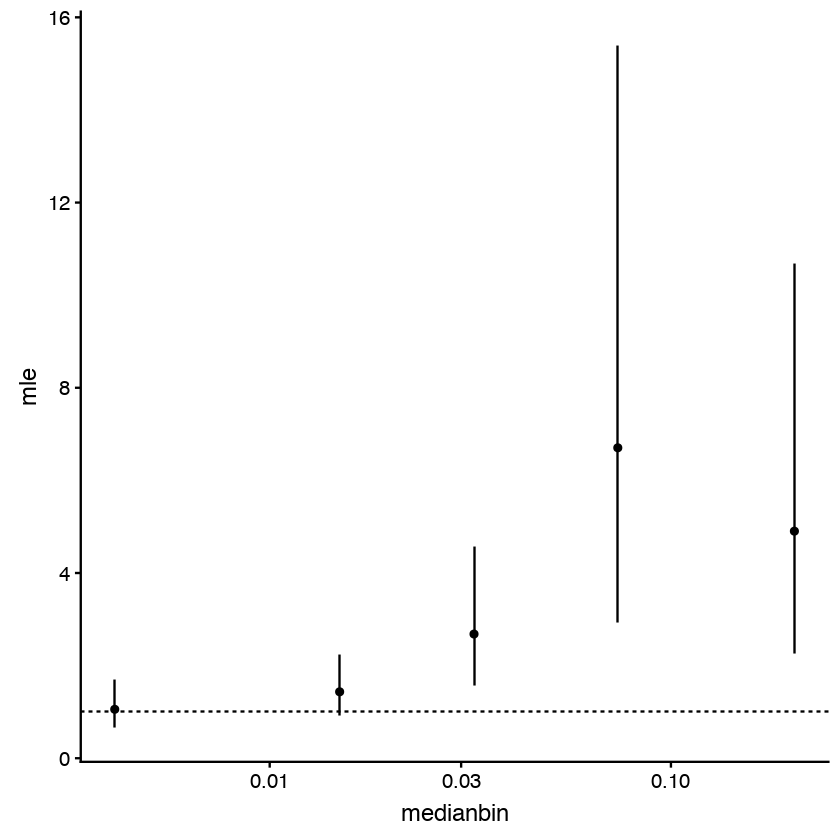

In [73]:
dfdnds %>%
filter(name == "wmis") %>%
ggplot(aes(y = mle, ymin = cilow, ymax = cihigh, x = medianbin)) +
geom_point() +
geom_hline(yintercept = 1.0, lty = 2) +
geom_linerange() +
scale_x_log10()

In [88]:
write_csv(dfdnds, "FinalFigures/data_for_figures/PD31182_bins.csv")
write_csv(dfdnds.genes, "FinalFigures/data_for_figures/PD31182_bins_genes.csv")

## 2 Skin data

Now I'll do the same analysis using data from [Martincorena et al. Science 2015](http://science.sciencemag.org/content/348/6237/880/tab-article-info).

In [66]:
df <- read_csv("data/skin/skin_mutation.csv")
data("dataset_normalskin_genes", package="dndscv")
target_genes

Parsed with column specification:
cols(
  patient = col_character(),
  chr = col_character(),
  pos = col_integer(),
  ref_nt = col_character(),
  mut_nt = col_character(),
  sampleID = col_character(),
  vaf = col_double(),
  size = col_double(),
  clone.area = col_double(),
  gene_name = col_character(),
  impact = col_character(),
  mutid = col_character()
)


[1] "ADAM29"   "ADAMTS18" "AJUBA"    "AKT1"     "AKT2"     "APOB"    
 [7] "ARID1A"   "ARID2"    "AURKA"    "BAI3"     "BRAF"     "CASP8"   
[13] "CCND1"    "CDH1"     "CDKN2A"   "CR2"      "CREBBP"   "CUL3"    
[19] "DICER1"   "EGFR"     "EPHA2"    "ERBB2"    "ERBB3"    "ERBB4"   
[25] "EZH2"     "FAT1"     "FAT4"     "FBXW7"    "FGFR1"    "FGFR2"   
[31] "FGFR3"    "FLG2"     "GRIN2A"   "GRM3"     "HRAS"     "IRF6"    
[37] "KCNH5"    "KEAP1"    "KMT2A"    "KMT2C"    "KMT2D"    "KRAS"    
[43] "MET"      "MUC17"    "NF1"      "NFE2L2"   "NOTCH1"   "NOTCH2"  
[49] "NOTCH3"   "NOTCH4"   "NRAS"     "NSD1"     "PCED1B"   "PIK3CA"  
[55] "PLCB1"    "PPP1R3A"  "PREX2"    "PTCH1"    "PTEN"     "PTPRT"   
[61] "RB1"      "RBM10"    "SALL1"    "SCN11A"   "SCN1A"    "SETD2"   
[67] "SMAD4"    "SMO"      "SOX2"     "SPHKAP"   "SUFU"     "TP53"    
[73] "TP63"     "TRIOBP"

In [67]:
minarea <- 0.03
maxarea <- 2.5
step <- 0.05
areacutoff <- seq(minarea, maxarea, step)

dfdnds <- data.frame()
dfdnds.genes <- data.frame()

for (cutoff in areacutoff){
  print(cutoff)
  x1 <- df %>%
    filter(clone.area < cutoff) #filter for mutations with ccf < cutoff
  x <- dndscv(x1, gene_list = target_genes,
              outp = 3, max_muts_per_gene_per_sample = Inf, 
              max_coding_muts_per_sample = Inf)
  out <- x$globaldnds %>%
    mutate(areacutoff = cutoff, nmutations = length(x1$patient))
  dfdnds <- rbind(dfdnds, out)
  combined <- left_join(x$sel_cv, x$sel_loc, by = c("gene_name", "n_syn", "n_mis", "n_non", "n_spl"))
  out2 <- combined %>%
    mutate(areacutoff = cutoff)
  dfdnds.genes <- bind_rows(dfdnds.genes, out2)
  print(x$globaldnds)
}

[1] 0.03


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.83).


     name      mle     cilow   cihigh
wmis wmis 1.037482 0.7364296 1.461604
wnon wnon 1.154040 0.5421908 2.456344
wspl wspl 1.423848 0.4096813 4.948585
wtru wtru 1.213696 0.6239409 2.360892
wall wall 1.051715 0.7506776 1.473474
[1] 0.08


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.07).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2.”    Regression model for indels (theta = 1.25)


     name      mle    cilow   cihigh
wmis wmis 1.206938 1.053023 1.383350
wnon wnon 1.691060 1.289734 2.217266
wspl wspl 2.194930 1.505110 3.200906
wtru wtru 1.830232 1.451754 2.307380
wall wall 1.259358 1.101371 1.440007
[1] 0.13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.82).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 0.706)


     name      mle    cilow   cihigh
wmis wmis 1.202285 1.074094 1.345775
wnon wnon 1.792658 1.443303 2.226576
wspl wspl 2.260949 1.667530 3.065545
wtru wtru 1.921952 1.595135 2.315728
wall wall 1.264070 1.131626 1.412015
[1] 0.18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.7).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.05)


     name      mle    cilow   cihigh
wmis wmis 1.227223 1.106569 1.361033
wnon wnon 1.867418 1.537109 2.268706
wspl wspl 2.326797 1.766937 3.064050
wtru wtru 1.993110 1.684456 2.358321
wall wall 1.294020 1.169021 1.432384
[1] 0.23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.67).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 0.665)


     name      mle    cilow   cihigh
wmis wmis 1.236855 1.120057 1.365832
wnon wnon 1.862398 1.547028 2.242058
wspl wspl 2.390166 1.837539 3.108991
wtru wtru 2.003521 1.706142 2.352734
wall wall 1.303831 1.182856 1.437178
[1] 0.28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.71).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 0.517)


     name      mle    cilow   cihigh
wmis wmis 1.239759 1.125700 1.365374
wnon wnon 1.858720 1.551278 2.227092
wspl wspl 2.454834 1.906919 3.160181
wtru wtru 2.018969 1.727180 2.360053
wall wall 1.307130 1.188940 1.437070
[1] 0.33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.65).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.524)


     name      mle    cilow   cihigh
wmis wmis 1.248726 1.135090 1.373737
wnon wnon 1.885860 1.579036 2.252304
wspl wspl 2.499893 1.949841 3.205117
wtru wtru 2.049852 1.758116 2.389998
wall wall 1.317899 1.200015 1.447364
[1] 0.38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.7).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.524)


     name      mle    cilow   cihigh
wmis wmis 1.261816 1.148064 1.386838
wnon wnon 1.926434 1.616712 2.295490
wspl wspl 2.522860 1.972970 3.226012
wtru wtru 2.086140 1.792472 2.427922
wall wall 1.332517 1.214419 1.462099
[1] 0.43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.7).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.524)


     name      mle    cilow   cihigh
wmis wmis 1.267971 1.154448 1.392656
wnon wnon 1.927863 1.619939 2.294318
wspl wspl 2.594289 2.037945 3.302510
wtru wtru 2.106649 1.812751 2.448196
wall wall 1.339662 1.221746 1.468958
[1] 0.48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.7).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.524)


     name      mle    cilow   cihigh
wmis wmis 1.268660 1.155550 1.392841
wnon wnon 1.953642 1.643839 2.321830
wspl wspl 2.684356 2.117108 3.403591
wtru wtru 2.149962 1.852650 2.494987
wall wall 1.343649 1.225893 1.472715
[1] 0.53


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.524)


     name      mle    cilow   cihigh
wmis wmis 1.283553 1.169527 1.408698
wnon wnon 1.945557 1.637963 2.310914
wspl wspl 2.663228 2.100920 3.376038
wtru wtru 2.138050 1.843140 2.480146
wall wall 1.356651 1.238155 1.486486
[1] 0.58


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.67).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, TP53, RBM10.”    Regression model for indels (theta = 0.524)


     name      mle    cilow   cihigh
wmis wmis 1.282333 1.168753 1.406952
wnon wnon 1.967059 1.658209 2.333434
wspl wspl 2.659314 2.098072 3.370691
wtru wtru 2.151855 1.856489 2.494213
wall wall 1.356898 1.238748 1.486317
[1] 0.63


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, TP53, RBM10.”    Regression model for indels (theta = 0.524)


     name      mle    cilow   cihigh
wmis wmis 1.284564 1.171087 1.409036
wnon wnon 1.987411 1.676864 2.355471
wspl wspl 2.641227 2.084342 3.346898
wtru wtru 2.162449 1.866699 2.505057
wall wall 1.359861 1.241763 1.489190
[1] 0.68


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.69).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, TP53, RBM10.”    Regression model for indels (theta = 0.524)


     name      mle    cilow   cihigh
wmis wmis 1.280830 1.167909 1.404668
wnon wnon 1.984463 1.674985 2.351122
wspl wspl 2.626248 2.072837 3.327410
wtru wtru 2.156265 1.861832 2.497259
wall wall 1.355908 1.238390 1.484578
[1] 0.73


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.69).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, TP53, RBM10.”    Regression model for indels (theta = 0.524)


     name      mle    cilow   cihigh
wmis wmis 1.281829 1.168920 1.405644
wnon wnon 1.981911 1.673364 2.347350
wspl wspl 2.626693 2.073252 3.327871
wtru wtru 2.153835 1.860086 2.493973
wall wall 1.356726 1.239239 1.485350
[1] 0.78


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.74).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, TP53, RBM10.”    Regression model for indels (theta = 0.524)


     name      mle    cilow   cihigh
wmis wmis 1.283292 1.170447 1.407018
wnon wnon 1.978879 1.670962 2.343538
wspl wspl 2.645536 2.090085 3.348600
wtru wtru 2.156719 1.862967 2.496790
wall wall 1.358090 1.240679 1.486611
[1] 0.83


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.74).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, TP53, RBM10.”    Regression model for indels (theta = 0.524)


     name      mle    cilow   cihigh
wmis wmis 1.284913 1.171946 1.408769
wnon wnon 1.977390 1.669752 2.341707
wspl wspl 2.636753 2.083341 3.337171
wtru wtru 2.153573 1.860292 2.493091
wall wall 1.359342 1.241839 1.487964
[1] 0.88


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, TP53, RBM10.”    Regression model for indels (theta = 0.389)


     name      mle    cilow   cihigh
wmis wmis 1.282834 1.170192 1.406319
wnon wnon 1.975038 1.667842 2.338816
wspl wspl 2.629147 2.077492 3.327287
wtru wtru 2.150044 1.857356 2.488855
wall wall 1.357014 1.239858 1.485240
[1] 0.93


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.284488 1.171717 1.408112
wnon wnon 1.976069 1.668722 2.340025
wspl wspl 2.631297 2.079202 3.329993
wtru wtru 2.151334 1.858475 2.490343
wall wall 1.358596 1.241317 1.486956
[1] 0.98


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.285283 1.172451 1.408973
wnon wnon 1.976141 1.668798 2.340087
wspl wspl 2.627241 2.076106 3.324685
wtru wtru 2.150502 1.857781 2.489344
wall wall 1.359300 1.241969 1.487716
[1] 1.03


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, NOTCH2, FAT1, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.288597 1.175525 1.412546
wnon wnon 1.975350 1.668198 2.339057
wspl wspl 2.627737 2.076600 3.325147
wtru wtru 2.149945 1.857343 2.488643
wall wall 1.362235 1.244693 1.490878
[1] 1.08


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.289798 1.176634 1.413845
wnon wnon 1.984079 1.675975 2.348824
wspl wspl 2.656603 2.101349 3.358577
wtru wtru 2.164101 1.870097 2.504327
wall wall 1.364580 1.246860 1.493415
[1] 1.13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.290478 1.177262 1.414580
wnon wnon 1.993611 1.684465 2.359493
wspl wspl 2.656267 2.101132 3.358072
wtru wtru 2.171051 1.876383 2.511994
wall wall 1.365877 1.248058 1.494818
[1] 1.18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.291659 1.178348 1.415866
wnon wnon 1.994918 1.685563 2.361050
wspl wspl 2.658080 2.102565 3.360367
wtru wtru 2.172496 1.877624 2.513675
wall wall 1.367044 1.249131 1.496087
[1] 1.23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.291659 1.178348 1.415866
wnon wnon 1.994918 1.685563 2.361050
wspl wspl 2.658080 2.102565 3.360367
wtru wtru 2.172496 1.877624 2.513675
wall wall 1.367044 1.249131 1.496087
[1] 1.28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.291998 1.178663 1.416230
wnon wnon 1.993705 1.684564 2.359579
wspl wspl 2.658017 2.102530 3.360262
wtru wtru 2.171502 1.876782 2.512503
wall wall 1.367277 1.249348 1.496337
[1] 1.33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.291708 1.178398 1.415912
wnon wnon 1.993686 1.684548 2.359556
wspl wspl 2.678779 2.120711 3.383704
wtru wtru 2.177291 1.882034 2.518868
wall wall 1.367413 1.249475 1.496483
[1] 1.38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.291708 1.178398 1.415912
wnon wnon 1.993686 1.684548 2.359556
wspl wspl 2.678779 2.120711 3.383704
wtru wtru 2.177291 1.882034 2.518868
wall wall 1.367413 1.249475 1.496483
[1] 1.43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.291708 1.178398 1.415912
wnon wnon 1.993686 1.684548 2.359556
wspl wspl 2.678779 2.120711 3.383704
wtru wtru 2.177291 1.882034 2.518868
wall wall 1.367413 1.249475 1.496483
[1] 1.48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.291708 1.178398 1.415912
wnon wnon 1.993686 1.684548 2.359556
wspl wspl 2.678779 2.120711 3.383704
wtru wtru 2.177291 1.882034 2.518868
wall wall 1.367413 1.249475 1.496483
[1] 1.53


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292513 1.179143 1.416783
wnon wnon 1.994577 1.685297 2.360614
wspl wspl 2.679998 2.121678 3.385241
wtru wtru 2.178272 1.882880 2.520007
wall wall 1.368202 1.250205 1.497336
[1] 1.58


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292513 1.179143 1.416783
wnon wnon 1.994577 1.685297 2.360614
wspl wspl 2.679998 2.121678 3.385241
wtru wtru 2.178272 1.882880 2.520007
wall wall 1.368202 1.250205 1.497336
[1] 1.63


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292513 1.179143 1.416783
wnon wnon 1.994577 1.685297 2.360614
wspl wspl 2.679998 2.121678 3.385241
wtru wtru 2.178272 1.882880 2.520007
wall wall 1.368202 1.250205 1.497336
[1] 1.68


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292513 1.179143 1.416783
wnon wnon 1.994577 1.685297 2.360614
wspl wspl 2.679998 2.121678 3.385241
wtru wtru 2.178272 1.882880 2.520007
wall wall 1.368202 1.250205 1.497336
[1] 1.73


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292513 1.179143 1.416783
wnon wnon 1.994577 1.685297 2.360614
wspl wspl 2.679998 2.121678 3.385241
wtru wtru 2.178272 1.882880 2.520007
wall wall 1.368202 1.250205 1.497336
[1] 1.78


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292513 1.179143 1.416783
wnon wnon 1.994577 1.685297 2.360614
wspl wspl 2.679998 2.121678 3.385241
wtru wtru 2.178272 1.882880 2.520007
wall wall 1.368202 1.250205 1.497336
[1] 1.83


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292513 1.179143 1.416783
wnon wnon 1.994577 1.685297 2.360614
wspl wspl 2.679998 2.121678 3.385241
wtru wtru 2.178272 1.882880 2.520007
wall wall 1.368202 1.250205 1.497336
[1] 1.88


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292513 1.179143 1.416783
wnon wnon 1.994577 1.685297 2.360614
wspl wspl 2.679998 2.121678 3.385241
wtru wtru 2.178272 1.882880 2.520007
wall wall 1.368202 1.250205 1.497336
[1] 1.93


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292513 1.179143 1.416783
wnon wnon 1.994577 1.685297 2.360614
wspl wspl 2.679998 2.121678 3.385241
wtru wtru 2.178272 1.882880 2.520007
wall wall 1.368202 1.250205 1.497336
[1] 1.98


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292513 1.179143 1.416783
wnon wnon 1.994577 1.685297 2.360614
wspl wspl 2.679998 2.121678 3.385241
wtru wtru 2.178272 1.882880 2.520007
wall wall 1.368202 1.250205 1.497336
[1] 2.03


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292513 1.179143 1.416783
wnon wnon 1.994577 1.685297 2.360614
wspl wspl 2.679998 2.121678 3.385241
wtru wtru 2.178272 1.882880 2.520007
wall wall 1.368202 1.250205 1.497336
[1] 2.08


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292985 1.179582 1.417291
wnon wnon 1.994306 1.685085 2.360271
wspl wspl 2.680350 2.121968 3.385666
wtru wtru 2.178124 1.882764 2.519820
wall wall 1.368617 1.250591 1.497782
[1] 2.13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292985 1.179582 1.417291
wnon wnon 1.994306 1.685085 2.360271
wspl wspl 2.680350 2.121968 3.385666
wtru wtru 2.178124 1.882764 2.519820
wall wall 1.368617 1.250591 1.497782
[1] 2.18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292985 1.179582 1.417291
wnon wnon 1.994306 1.685085 2.360271
wspl wspl 2.680350 2.121968 3.385666
wtru wtru 2.178124 1.882764 2.519820
wall wall 1.368617 1.250591 1.497782
[1] 2.23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292985 1.179582 1.417291
wnon wnon 1.994306 1.685085 2.360271
wspl wspl 2.680350 2.121968 3.385666
wtru wtru 2.178124 1.882764 2.519820
wall wall 1.368617 1.250591 1.497782
[1] 2.28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292985 1.179582 1.417291
wnon wnon 1.994306 1.685085 2.360271
wspl wspl 2.680350 2.121968 3.385666
wtru wtru 2.178124 1.882764 2.519820
wall wall 1.368617 1.250591 1.497782
[1] 2.33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292985 1.179582 1.417291
wnon wnon 1.994306 1.685085 2.360271
wspl wspl 2.680350 2.121968 3.385666
wtru wtru 2.178124 1.882764 2.519820
wall wall 1.368617 1.250591 1.497782
[1] 2.38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292985 1.179582 1.417291
wnon wnon 1.994306 1.685085 2.360271
wspl wspl 2.680350 2.121968 3.385666
wtru wtru 2.178124 1.882764 2.519820
wall wall 1.368617 1.250591 1.497782
[1] 2.43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292985 1.179582 1.417291
wnon wnon 1.994306 1.685085 2.360271
wspl wspl 2.680350 2.121968 3.385666
wtru wtru 2.178124 1.882764 2.519820
wall wall 1.368617 1.250591 1.497782
[1] 2.48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53, RBM10.”    Regression model for indels (theta = 0.48)


     name      mle    cilow   cihigh
wmis wmis 1.292985 1.179582 1.417291
wnon wnon 1.994306 1.685085 2.360271
wspl wspl 2.680350 2.121968 3.385666
wtru wtru 2.178124 1.882764 2.519820
wall wall 1.368617 1.250591 1.497782


In [68]:
write_csv(dfdnds, "data/skin/dnds_combined.csv")
write_csv(dfdnds.genes, "data/skin/dnds_genes_combined.csv")

In [69]:

dfdnds.patient <- data.frame()
dfdnds.genes.patient <- data.frame()
i <- 1
for (p in unique(df$patient)){
  print(p)
  print(i)
  for (cutoff in areacutoff){
    print(cutoff)
    x1 <- df %>%
      filter(patient == p) %>%
      filter(clone.area < cutoff) #filter for mutations with ccf < cutoff
    x <- dndscv(x1, gene_list = target_genes,
                outp = 3, max_muts_per_gene_per_sample = Inf, 
                max_coding_muts_per_sample = Inf)
    out <- x$globaldnds %>%
        mutate(areacutoff = cutoff, nmutations = length(x1$donor), patient = p)
    dfdnds.patient <- rbind(dfdnds.patient, out)
    combined <- left_join(x$sel_cv, x$sel_loc, by = c("gene_name", "n_syn", "n_mis", "n_non", "n_spl"))
    out2 <- combined %>%
      mutate(areacutoff = cutoff, patient = p)
    dfdnds.genes.patient <- bind_rows(dfdnds.genes.patient, out2)
    print(x$globaldnds)
  }
  i + i +1
}

[1] "PD13634"
[1] 1
[1] 0.03


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 5.69e+03).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name       mle     cilow    cihigh
wmis wmis 0.9190661 0.5052408  1.671841
wnon wnon 1.3358329 0.4118339  4.332935
wspl wspl 2.1834403 0.2623568 18.171482
wtru wtru 1.4683526 0.5077709  4.246126
wall wall 0.9708999 0.5429471  1.736167
[1] 0.08


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.95).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name       mle     cilow   cihigh
wmis wmis 0.9959472 0.7620217 1.301683
wnon wnon 0.8250718 0.4244530 1.603813
wspl wspl 1.4724166 0.6373717 3.401486
wtru wtru 0.9996541 0.5837059 1.712007
wall wall 0.9944332 0.7640813 1.294231
[1] 0.13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.76).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.093470 0.8743743 1.367466
wnon wnon 1.414162 0.8864907 2.255922
wspl wspl 1.324316 0.6618203 2.649985
wtru wtru 1.386586 0.9271860 2.073607
wall wall 1.120317 0.8992776 1.395687
[1] 0.18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.71).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.109635 0.9025157 1.364287
wnon wnon 1.427183 0.9311144 2.187541
wspl wspl 1.369767 0.7259423 2.584587
wtru wtru 1.409896 0.9749070 2.038970
wall wall 1.137234 0.9282358 1.393290
[1] 0.23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.65).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.159081 0.9517162 1.411627
wnon wnon 1.510567 1.0091897 2.261036
wspl wspl 1.397754 0.7587234 2.575003
wtru wtru 1.476966 1.0399062 2.097717
wall wall 1.187691 0.9782936 1.441908
[1] 0.28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.83).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.134397 0.9363488 1.374334
wnon wnon 1.388878 0.9310222 2.071898
wspl wspl 1.417044 0.7848669 2.558412
wtru wtru 1.397104 0.9886501 1.974307
wall wall 1.157583 0.9583419 1.398247
[1] 0.33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.126822 0.9320992 1.362223
wnon wnon 1.379521 0.9298607 2.046627
wspl wspl 1.387474 0.7695618 2.501531
wtru wtru 1.381823 0.9815416 1.945342
wall wall 1.149467 0.9536408 1.385506
[1] 0.38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.86).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.107499 0.9183387 1.335624
wnon wnon 1.414184 0.9617321 2.079495
wspl wspl 1.571302 0.8997498 2.744084
wtru wtru 1.459211 1.0471987 2.033326
wall wall 1.138265 0.9467953 1.368455
[1] 0.43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.87).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.104957 0.9172123 1.331130
wnon wnon 1.391009 0.9468465 2.043528
wspl wspl 1.805948 1.0725137 3.040938
wtru wtru 1.510979 1.0915921 2.091492
wall wall 1.139744 0.9491051 1.368674
[1] 0.48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.96).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.100640 0.9151509 1.323726
wnon wnon 1.359224 0.9262401 1.994612
wspl wspl 1.966300 1.1915047 3.244920
wtru wtru 1.533557 1.1128797 2.113255
wall wall 1.136909 0.9482922 1.363041
[1] 0.53


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.96).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.119897 0.9316411 1.346195
wnon wnon 1.358413 0.9260640 1.992612
wspl wspl 1.988735 1.2052120 3.281636
wtru wtru 1.537854 1.1162956 2.118610
wall wall 1.154773 0.9636209 1.383844
[1] 0.58


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.92).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.124795 0.9363684 1.351139
wnon wnon 1.426483 0.9801633 2.076037
wspl wspl 1.996898 1.2103730 3.294522
wtru wtru 1.587748 1.1572761 2.178341
wall wall 1.163805 0.9718801 1.393630
[1] 0.63


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.93).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.125771 0.9377534 1.351486
wnon wnon 1.485426 1.0277726 2.146867
wspl wspl 1.998909 1.2118448 3.297154
wtru wtru 1.629627 1.1922014 2.227546
wall wall 1.168587 0.9765154 1.398438
[1] 0.68


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.01).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.121889 0.9349436 1.346215
wnon wnon 1.454635 1.0066870 2.101906
wspl wspl 1.967816 1.1940138 3.243095
wtru wtru 1.598497 1.1697491 2.184394
wall wall 1.162591 0.9719235 1.390662
[1] 0.73


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.01).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.121889 0.9349436 1.346215
wnon wnon 1.454635 1.0066870 2.101906
wspl wspl 1.967816 1.1940138 3.243095
wtru wtru 1.598497 1.1697491 2.184394
wall wall 1.162591 0.9719235 1.390662
[1] 0.78


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.01).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.128568 0.9406567 1.354019
wnon wnon 1.452948 1.0057111 2.099069
wspl wspl 1.975307 1.1986012 3.255325
wtru wtru 1.598831 1.1701367 2.184583
wall wall 1.168731 0.9771902 1.397816
[1] 0.83


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.01).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.132649 0.9441571 1.358772
wnon wnon 1.450894 1.0043859 2.095900
wspl wspl 1.947998 1.1829755 3.207757
wtru wtru 1.590943 1.1644792 2.173588
wall wall 1.171839 0.9798549 1.401438
[1] 0.88


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.127297 0.9400212 1.351882
wnon wnon 1.446150 1.0012405 2.088758
wspl wspl 1.941002 1.1788501 3.195900
wtru wtru 1.585589 1.1607480 2.165925
wall wall 1.166405 0.9756504 1.394455
[1] 0.93


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.127297 0.9400212 1.351882
wnon wnon 1.446150 1.0012405 2.088758
wspl wspl 1.941002 1.1788501 3.195900
wtru wtru 1.585589 1.1607480 2.165925
wall wall 1.166405 0.9756504 1.394455
[1] 0.98


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.127297 0.9400212 1.351882
wnon wnon 1.446150 1.0012405 2.088758
wspl wspl 1.941002 1.1788501 3.195900
wtru wtru 1.585589 1.1607480 2.165925
wall wall 1.166405 0.9756504 1.394455
[1] 1.03


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.08


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.53


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.58


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.63


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.68


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.73


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.78


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.83


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.88


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.93


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 1.98


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 2.03


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 2.08


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 2.13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 2.18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 2.23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 2.28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 2.33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 2.38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 2.43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] 2.48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.129084 0.9415724 1.353938
wnon wnon 1.445385 1.0007872 2.087494
wspl wspl 1.942178 1.1796178 3.197694
wtru wtru 1.585240 1.1605532 2.165335
wall wall 1.167994 0.9770319 1.396280
[1] "PD18003"
[1] 1
[1] 0.03


[1] Loading the environment...
[2] Annotating the mutations...
[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 7.15).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name       mle     cilow    cihigh
wmis wmis 0.9360599 0.5075689  1.726284
wnon wnon 1.2843155 0.3380496  4.879362
wspl wspl 3.0813833 0.6024808 15.759711
wtru wtru 1.7092459 0.5762137  5.070205
wall wall 0.9936811 0.5453045  1.810735
[1] 0.08


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.18).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1.”    Regression model for indels (theta = 0.49)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.255639 1.008270 1.563697
wnon wnon 2.204453 1.483167 3.276512
wspl wspl 2.597983 1.489488 4.531432
wtru wtru 2.316459 1.643118 3.265731
wall wall 1.348217 1.087291 1.671759
[1] 0.13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.05).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1.”    Regression model for indels (theta = 12.8)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.207515 1.011798 1.441091
wnon wnon 1.919301 1.387313 2.655288
wspl wspl 2.762490 1.767532 4.317518
wtru wtru 2.140825 1.618899 2.831017
wall wall 1.289882 1.084714 1.533856
[1] 0.18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.88).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 22.1)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.246372 1.062201 1.462475
wnon wnon 2.081273 1.563427 2.770642
wspl wspl 2.787769 1.871179 4.153349
wtru wtru 2.269484 1.770695 2.908778
wall wall 1.337710 1.143753 1.564559
[1] 0.23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.8).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 0.78)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.265967 1.086567 1.474987
wnon wnon 1.981741 1.505614 2.608436
wspl wspl 2.956413 2.024992 4.316254
wtru wtru 2.230122 1.758159 2.828779
wall wall 1.352611 1.164490 1.571122
[1] 0.28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.73).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.271856 1.097155 1.474374
wnon wnon 2.011338 1.544134 2.619903
wspl wspl 2.969597 2.069217 4.261760
wtru wtru 2.259560 1.797828 2.839878
wall wall 1.360183 1.176761 1.572194
[1] 0.33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.67).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.291341 1.116111 1.494082
wnon wnon 2.065516 1.593384 2.677545
wspl wspl 3.047545 2.139830 4.340314
wtru wtru 2.320826 1.854136 2.904982
wall wall 1.382437 1.198194 1.595010
[1] 0.38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.66).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.330508 1.151652 1.537141
wnon wnon 2.120924 1.640084 2.742736
wspl wspl 3.002865 2.109787 4.273986
wtru wtru 2.352553 1.882414 2.940112
wall wall 1.419775 1.232167 1.635946
[1] 0.43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.61).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.334663 1.156644 1.540080
wnon wnon 2.108248 1.634252 2.719722
wspl wspl 3.026801 2.135080 4.290950
wtru wtru 2.348083 1.882823 2.928313
wall wall 1.423481 1.236841 1.638285
[1] 0.48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.6).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.339824 1.161580 1.545418
wnon wnon 2.194040 1.706420 2.820999
wspl wspl 3.157093 2.239320 4.451011
wtru wtru 2.446027 1.966693 3.042187
wall wall 1.436566 1.248770 1.652605
[1] 0.53


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.55).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.350504 1.171905 1.556321
wnon wnon 2.172144 1.692171 2.788257
wspl wspl 3.086335 2.190076 4.349374
wtru wtru 2.410999 1.940858 2.995024
wall wall 1.444250 1.256536 1.660006
[1] 0.58


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.55).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.350343 1.172094 1.555700
wnon wnon 2.197784 1.714893 2.816652
wspl wspl 3.086421 2.190343 4.349089
wtru wtru 2.429012 1.957194 3.014570
wall wall 1.445923 1.258359 1.661445
[1] 0.63


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.53).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.358882 1.179989 1.564896
wnon wnon 2.220295 1.733802 2.843296
wspl wspl 3.066867 2.177680 4.319126
wtru wtru 2.442132 1.968905 3.029100
wall wall 1.454717 1.266496 1.670910
[1] 0.68


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.6).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.357382 1.179006 1.562745
wnon wnon 2.242611 1.752643 2.869554
wspl wspl 3.063913 2.175813 4.314508
wtru wtru 2.458099 1.982799 3.047335
wall wall 1.454474 1.266626 1.670181
[1] 0.73


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.61).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.356598 1.178615 1.561458
wnon wnon 2.229017 1.742512 2.851353
wspl wspl 3.060429 2.173534 4.309216
wtru wtru 2.446199 1.973628 3.031925
wall wall 1.452739 1.265411 1.667799
[1] 0.78


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.358076 1.180262 1.562680
wnon wnon 2.225696 1.740219 2.846609
wspl wspl 3.103864 2.210076 4.359113
wtru wtru 2.455618 1.982205 3.042097
wall wall 1.454431 1.267256 1.669251
[1] 0.83


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.359289 1.181342 1.564039
wnon wnon 2.223495 1.738595 2.843635
wspl wspl 3.105316 2.211131 4.361111
wtru wtru 2.454075 1.981025 3.040086
wall wall 1.455422 1.268142 1.670360
[1] 0.88


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.363412 1.185010 1.568671
wnon wnon 2.228237 1.742285 2.849729
wspl wspl 3.101339 2.208604 4.354924
wtru wtru 2.457157 1.983548 3.043848
wall wall 1.459297 1.271590 1.674713
[1] 0.93


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.364528 1.186007 1.569920
wnon wnon 2.227605 1.741849 2.848826
wspl wspl 3.102242 2.209288 4.356113
wtru wtru 2.456802 1.983305 3.043342
wall wall 1.460274 1.272463 1.675805
[1] 0.98


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.366405 1.187668 1.572040
wnon wnon 2.227840 1.742089 2.849035
wspl wspl 3.091468 2.201987 4.340249
wtru wtru 2.454734 1.981729 3.040638
wall wall 1.461939 1.273942 1.677678
[1] 1.03


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, TP53, NOTCH2.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.373129 1.193652 1.579591
wnon wnon 2.226893 1.741530 2.847525
wspl wspl 3.091958 2.202648 4.340324
wtru wtru 2.453964 1.981219 3.039512
wall wall 1.467879 1.279234 1.684343
[1] 1.08


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.375952 1.196152 1.582779
wnon wnon 2.246950 1.758378 2.871273
wspl wspl 3.159962 2.256969 4.424235
wtru wtru 2.486836 2.009310 3.077849
wall wall 1.473444 1.284162 1.690626
[1] 1.13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.376793 1.196905 1.583719
wnon wnon 2.247879 1.759104 2.872463
wspl wspl 3.156538 2.254694 4.419106
wtru wtru 2.486915 2.009400 3.077908
wall wall 1.474197 1.284836 1.691465
[1] 1.18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.379614 1.199383 1.586929
wnon wnon 2.251241 1.761707 2.876803
wspl wspl 3.161421 2.258175 4.425955
wtru wtru 2.490685 2.012417 3.082617
wall wall 1.476991 1.287292 1.694644
[1] 1.23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.379614 1.199383 1.586929
wnon wnon 2.251241 1.761707 2.876803
wspl wspl 3.161421 2.258175 4.425955
wtru wtru 2.490685 2.012417 3.082617
wall wall 1.476991 1.287292 1.694644
[1] 1.28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.380420 1.200103 1.587829
wnon wnon 2.248308 1.759505 2.872904
wspl wspl 3.161245 2.258103 4.425605
wtru wtru 2.488210 2.010478 3.079462
wall wall 1.477535 1.287780 1.695250
[1] 1.33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.380420 1.200103 1.587829
wnon wnon 2.248308 1.759505 2.872904
wspl wspl 3.161245 2.258103 4.425605
wtru wtru 2.488210 2.010478 3.079462
wall wall 1.477535 1.287780 1.695250
[1] 1.38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.380420 1.200103 1.587829
wnon wnon 2.248308 1.759505 2.872904
wspl wspl 3.161245 2.258103 4.425605
wtru wtru 2.488210 2.010478 3.079462
wall wall 1.477535 1.287780 1.695250
[1] 1.43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.380420 1.200103 1.587829
wnon wnon 2.248308 1.759505 2.872904
wspl wspl 3.161245 2.258103 4.425605
wtru wtru 2.488210 2.010478 3.079462
wall wall 1.477535 1.287780 1.695250
[1] 1.48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.380420 1.200103 1.587829
wnon wnon 2.248308 1.759505 2.872904
wspl wspl 3.161245 2.258103 4.425605
wtru wtru 2.488210 2.010478 3.079462
wall wall 1.477535 1.287780 1.695250
[1] 1.53


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.382326 1.201793 1.589979
wnon wnon 2.250576 1.761268 2.875820
wspl wspl 3.164470 2.260412 4.430108
wtru wtru 2.490740 2.012512 3.082608
wall wall 1.479405 1.289439 1.697359
[1] 1.58


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.382326 1.201793 1.589979
wnon wnon 2.250576 1.761268 2.875820
wspl wspl 3.164470 2.260412 4.430108
wtru wtru 2.490740 2.012512 3.082608
wall wall 1.479405 1.289439 1.697359
[1] 1.63


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.382326 1.201793 1.589979
wnon wnon 2.250576 1.761268 2.875820
wspl wspl 3.164470 2.260412 4.430108
wtru wtru 2.490740 2.012512 3.082608
wall wall 1.479405 1.289439 1.697359
[1] 1.68


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.382326 1.201793 1.589979
wnon wnon 2.250576 1.761268 2.875820
wspl wspl 3.164470 2.260412 4.430108
wtru wtru 2.490740 2.012512 3.082608
wall wall 1.479405 1.289439 1.697359
[1] 1.73


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.382326 1.201793 1.589979
wnon wnon 2.250576 1.761268 2.875820
wspl wspl 3.164470 2.260412 4.430108
wtru wtru 2.490740 2.012512 3.082608
wall wall 1.479405 1.289439 1.697359
[1] 1.78


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.382326 1.201793 1.589979
wnon wnon 2.250576 1.761268 2.875820
wspl wspl 3.164470 2.260412 4.430108
wtru wtru 2.490740 2.012512 3.082608
wall wall 1.479405 1.289439 1.697359
[1] 1.83


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.382326 1.201793 1.589979
wnon wnon 2.250576 1.761268 2.875820
wspl wspl 3.164470 2.260412 4.430108
wtru wtru 2.490740 2.012512 3.082608
wall wall 1.479405 1.289439 1.697359
[1] 1.88


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.382326 1.201793 1.589979
wnon wnon 2.250576 1.761268 2.875820
wspl wspl 3.164470 2.260412 4.430108
wtru wtru 2.490740 2.012512 3.082608
wall wall 1.479405 1.289439 1.697359
[1] 1.93


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.382326 1.201793 1.589979
wnon wnon 2.250576 1.761268 2.875820
wspl wspl 3.164470 2.260412 4.430108
wtru wtru 2.490740 2.012512 3.082608
wall wall 1.479405 1.289439 1.697359
[1] 1.98


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.382326 1.201793 1.589979
wnon wnon 2.250576 1.761268 2.875820
wspl wspl 3.164470 2.260412 4.430108
wtru wtru 2.490740 2.012512 3.082608
wall wall 1.479405 1.289439 1.697359
[1] 2.03


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.382326 1.201793 1.589979
wnon wnon 2.250576 1.761268 2.875820
wspl wspl 3.164470 2.260412 4.430108
wtru wtru 2.490740 2.012512 3.082608
wall wall 1.479405 1.289439 1.697359
[1] 2.08


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.383440 1.202788 1.591226
wnon wnon 2.249944 1.760832 2.874918
wspl wspl 3.165376 2.261099 4.431297
wtru wtru 2.490382 2.012265 3.082098
wall wall 1.480381 1.290310 1.698449
[1] 2.13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.383440 1.202788 1.591226
wnon wnon 2.249944 1.760832 2.874918
wspl wspl 3.165376 2.261099 4.431297
wtru wtru 2.490382 2.012265 3.082098
wall wall 1.480381 1.290310 1.698449
[1] 2.18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.383440 1.202788 1.591226
wnon wnon 2.249944 1.760832 2.874918
wspl wspl 3.165376 2.261099 4.431297
wtru wtru 2.490382 2.012265 3.082098
wall wall 1.480381 1.290310 1.698449
[1] 2.23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.383440 1.202788 1.591226
wnon wnon 2.249944 1.760832 2.874918
wspl wspl 3.165376 2.261099 4.431297
wtru wtru 2.490382 2.012265 3.082098
wall wall 1.480381 1.290310 1.698449
[1] 2.28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.383440 1.202788 1.591226
wnon wnon 2.249944 1.760832 2.874918
wspl wspl 3.165376 2.261099 4.431297
wtru wtru 2.490382 2.012265 3.082098
wall wall 1.480381 1.290310 1.698449
[1] 2.33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.383440 1.202788 1.591226
wnon wnon 2.249944 1.760832 2.874918
wspl wspl 3.165376 2.261099 4.431297
wtru wtru 2.490382 2.012265 3.082098
wall wall 1.480381 1.290310 1.698449
[1] 2.38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.383440 1.202788 1.591226
wnon wnon 2.249944 1.760832 2.874918
wspl wspl 3.165376 2.261099 4.431297
wtru wtru 2.490382 2.012265 3.082098
wall wall 1.480381 1.290310 1.698449
[1] 2.43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.383440 1.202788 1.591226
wnon wnon 2.249944 1.760832 2.874918
wspl wspl 3.165376 2.261099 4.431297
wtru wtru 2.490382 2.012265 3.082098
wall wall 1.480381 1.290310 1.698449
[1] 2.48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.68).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH1, FAT1, NOTCH2, TP53.”    Regression model for indels (theta = 1.19)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.383440 1.202788 1.591226
wnon wnon 2.249944 1.760832 2.874918
wspl wspl 3.165376 2.261099 4.431297
wtru wtru 2.490382 2.012265 3.082098
wall wall 1.480381 1.290310 1.698449
[1] "PD20399"
[1] 1
[1] 0.03


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
Warning message:
“glm.fit: fitted rates numerically 0 occurred”[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.78).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name          mle     cilow   cihigh
wmis wmis 1.159052e+00 0.6351110 2.115225
wnon wnon 9.917755e-01 0.2124781 4.629270
wspl wspl 5.497088e-08 0.0000000      Inf
wtru wtru 6.538468e-01 0.1428983 2.991747
wall wall 1.130038e+00 0.6221841 2.052423
[1] 0.08


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.05).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow   cihigh
wmis wmis 1.254616 0.9790492 1.607746
wnon wnon 2.030307 1.2549954 3.284591
wspl wspl 2.216889 1.1174294 4.398128
wtru wtru 2.085104 1.3770377 3.157256
wall wall 1.321637 1.0356815 1.686546
[1] 0.13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.94).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.45e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.232887 0.999590 1.520633
wnon wnon 1.988293 1.335478 2.960221
wspl wspl 2.343510 1.343843 4.086818
wtru wtru 2.090491 1.483758 2.945327
wall wall 1.303323 1.060566 1.601647
[1] 0.18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.53).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.268770 1.041962 1.544949
wnon wnon 2.005100 1.388222 2.896098
wspl wspl 2.451414 1.465517 4.100553
wtru wtru 2.130218 1.550843 2.926039
wall wall 1.341423 1.105420 1.627811
[1] 0.23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.45).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.236753 1.021751 1.496996
wnon wnon 2.055998 1.447270 2.920759
wspl wspl 2.327956 1.410170 3.843067
wtru wtru 2.133024 1.572115 2.894055
wall wall 1.313468 1.088878 1.584380
[1] 0.28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.53).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.247569 1.034142 1.505045
wnon wnon 2.107530 1.492552 2.975899
wspl wspl 2.283330 1.386323 3.760737
wtru wtru 2.157604 1.597205 2.914625
wall wall 1.324874 1.101889 1.592984
[1] 0.33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.45).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.251066 1.038857 1.506622
wnon wnon 2.117026 1.507264 2.973466
wspl wspl 2.357179 1.444429 3.846707
wtru wtru 2.184601 1.624633 2.937574
wall wall 1.330701 1.108697 1.597157
[1] 0.38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.45).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.259306 1.045990 1.516126
wnon wnon 2.196285 1.569893 3.072609
wspl wspl 2.362134 1.447895 3.853649
wtru wtru 2.242959 1.671883 3.009102
wall wall 1.342988 1.119227 1.611485
[1] 0.43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.271363 1.056876 1.529378
wnon wnon 2.249567 1.611479 3.140315
wspl wspl 2.378269 1.458107 3.879113
wtru wtru 2.285772 1.706148 3.062310
wall wall 1.356920 1.131726 1.626924
[1] 0.48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.272558 1.058516 1.529882
wnon wnon 2.245902 1.609269 3.134389
wspl wspl 2.348110 1.440732 3.826959
wtru wtru 2.274899 1.698730 3.046490
wall wall 1.357142 1.132564 1.626253
[1] 0.53


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.43).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.279270 1.064221 1.537775
wnon wnon 2.231291 1.598836 3.113929
wspl wspl 2.356544 1.445905 3.840710
wtru wtru 2.266611 1.692523 3.035426
wall wall 1.362659 1.137267 1.632721
[1] 0.58


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.44).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.277052 1.062913 1.534332
wnon wnon 2.210718 1.584768 3.083907
wspl wspl 2.345978 1.439883 3.822265
wtru wtru 2.248736 1.679846 3.010284
wall wall 1.359392 1.135111 1.627989
[1] 0.63


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.44).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.277052 1.062913 1.534332
wnon wnon 2.210718 1.584768 3.083907
wspl wspl 2.345978 1.439883 3.822265
wtru wtru 2.248736 1.679846 3.010284
wall wall 1.359392 1.135111 1.627989
[1] 0.68


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.44).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.277052 1.062913 1.534332
wnon wnon 2.210718 1.584768 3.083907
wspl wspl 2.345978 1.439883 3.822265
wtru wtru 2.248736 1.679846 3.010284
wall wall 1.359392 1.135111 1.627989
[1] 0.73


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.44).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.280179 1.065571 1.538009
wnon wnon 2.186658 1.567411 3.050553
wspl wspl 2.348675 1.441564 3.826588
wtru wtru 2.231895 1.667171 2.987910
wall wall 1.361195 1.136668 1.630074
[1] 0.78


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.44).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.280179 1.065571 1.538009
wnon wnon 2.186658 1.567411 3.050553
wspl wspl 2.348675 1.441564 3.826588
wtru wtru 2.231895 1.667171 2.987910
wall wall 1.361195 1.136668 1.630074
[1] 0.83


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.44).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.280179 1.065571 1.538009
wnon wnon 2.186658 1.567411 3.050553
wspl wspl 2.348675 1.441564 3.826588
wtru wtru 2.231895 1.667171 2.987910
wall wall 1.361195 1.136668 1.630074
[1] 0.88


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.38).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.271590 1.058847 1.527079
wnon wnon 2.176190 1.560230 3.035325
wspl wspl 2.336367 1.434209 3.806005
wtru wtru 2.220924 1.659360 2.972535
wall wall 1.352257 1.129661 1.618715
[1] 0.93


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.38).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276260 1.062793 1.532604
wnon wnon 2.181879 1.564252 3.043368
wspl wspl 2.342795 1.438149 3.816497
wtru wtru 2.226820 1.663710 2.980524
wall wall 1.356879 1.133568 1.624182
[1] 0.98


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.38).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276260 1.062793 1.532604
wnon wnon 2.181879 1.564252 3.043368
wspl wspl 2.342795 1.438149 3.816497
wtru wtru 2.226820 1.663710 2.980524
wall wall 1.356879 1.133568 1.624182
[1] 1.03


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.38).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276260 1.062793 1.532604
wnon wnon 2.181879 1.564252 3.043368
wspl wspl 2.342795 1.438149 3.816497
wtru wtru 2.226820 1.663710 2.980524
wall wall 1.356879 1.133568 1.624182
[1] 1.08


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.38).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276260 1.062793 1.532604
wnon wnon 2.181879 1.564252 3.043368
wspl wspl 2.342795 1.438149 3.816497
wtru wtru 2.226820 1.663710 2.980524
wall wall 1.356879 1.133568 1.624182
[1] 1.13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.277475 1.063816 1.534046
wnon wnon 2.219794 1.594539 3.090227
wspl wspl 2.345851 1.440025 3.821471
wtru wtru 2.254963 1.686706 3.014667
wall wall 1.360746 1.136857 1.628728
[1] 1.18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.277475 1.063816 1.534046
wnon wnon 2.219794 1.594539 3.090227
wspl wspl 2.345851 1.440025 3.821471
wtru wtru 2.254963 1.686706 3.014667
wall wall 1.360746 1.136857 1.628728
[1] 1.23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.277475 1.063816 1.534046
wnon wnon 2.219794 1.594539 3.090227
wspl wspl 2.345851 1.440025 3.821471
wtru wtru 2.254963 1.686706 3.014667
wall wall 1.360746 1.136857 1.628728
[1] 1.28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.277475 1.063816 1.534046
wnon wnon 2.219794 1.594539 3.090227
wspl wspl 2.345851 1.440025 3.821471
wtru wtru 2.254963 1.686706 3.014667
wall wall 1.360746 1.136857 1.628728
[1] 1.33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 1.38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 1.43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 1.48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 1.53


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 1.58


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 1.63


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 1.68


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 1.73


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 1.78


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 1.83


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 1.88


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 1.93


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 1.98


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 2.03


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 2.08


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 2.13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 2.18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 2.23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 2.28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 2.33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 2.38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 2.43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] 2.48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.39).
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“    Genes were excluded from the indel background model based on the substitution data: NOTCH2, NOTCH1.”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for indels (theta = 6.78e+03)
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow   cihigh
wmis wmis 1.276326 1.062856 1.532669
wnon wnon 2.219666 1.594449 3.090042
wspl wspl 2.429065 1.502681 3.926552
wtru wtru 2.278386 1.705999 3.042817
wall wall 1.361287 1.137328 1.629346
[1] "PD21910"
[1] 1
[1] 0.03


[1] Loading the environment...
[2] Annotating the mutations...
[3] Estimating global rates...
Warning message:
“glm.fit: fitted rates numerically 0 occurred”Warning message:
“glm.fit: fitted rates numerically 0 occurred”[4] Running dNdSloc...
[5] Running dNdScv...
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”    Regression model for substitutions (theta = 5.17e+03).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name          mle     cilow   cihigh
wmis wmis 2.644038e+00 0.2936180 23.80963
wnon wnon 2.069169e-09 0.0000000      Inf
wspl wspl 4.993680e-07 0.0000000      Inf
wtru wtru 2.775044e-08 0.0000000      Inf
wall wall 2.156958e+00 0.2441342 19.05701
[1] 0.08


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 9.25).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name       mle     cilow    cihigh
wmis wmis 1.8576816 0.9908212  3.482950
wnon wnon 0.5228357 0.0655607  4.169527
wspl wspl 3.3091775 0.3785006 28.931671
wtru wtru 0.9194588 0.1986686  4.255351
wall wall 1.7644880 0.9458235  3.291753
[1] 0.13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.95).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.605220 0.9628757  2.676077
wnon wnon 1.470919 0.4727855  4.576288
wspl wspl 3.972226 0.8313693 18.979028
wtru wtru 1.900794 0.7257828  4.978101
wall wall 1.621917 0.9789037  2.687305
[1] 0.18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 1.57).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.459440 0.9289243  2.292937
wnon wnon 1.504260 0.5827637  3.882876
wspl wspl 3.706801 0.9987026 13.758222
wtru wtru 1.904123 0.8460739  4.285304
wall wall 1.486845 0.9517024  2.322898
[1] 0.23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 4.66).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.390054 0.9104731  2.122249
wnon wnon 1.591364 0.6875186  3.683448
wspl wspl 4.261582 1.3480960 13.471652
wtru wtru 2.056281 0.9997284  4.229439
wall wall 1.436904 0.9470128  2.180216
[1] 0.28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.27).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.466763 0.9704238  2.216962
wnon wnon 1.624735 0.7041389  3.748924
wspl wspl 5.914425 2.2119110 15.814573
wtru wtru 2.449919 1.2384094  4.846623
wall wall 1.535450 1.0221295  2.306563
[1] 0.33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.23).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.507410 0.9996618  2.273053
wnon wnon 1.733793 0.7787110  3.860274
wspl wspl 5.997719 2.2463590 16.013753
wtru wtru 2.514749 1.2907884  4.899304
wall wall 1.580416 1.0541942  2.369310
[1] 0.38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 4.45).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.502630 1.0087578  2.238293
wnon wnon 1.611855 0.7313756  3.552315
wspl wspl 5.469263 2.0630520 14.499314
wtru wtru 2.316624 1.2013176  4.467382
wall wall 1.559601 1.0526542  2.310687
[1] 0.43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 8.14).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.530314 1.0338850  2.265107
wnon wnon 1.615661 0.7347939  3.552505
wspl wspl 5.013043 1.8956817 13.256762
wtru wtru 2.273496 1.1822170  4.372110
wall wall 1.583213 1.0751490  2.331363
[1] 0.48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 8.14).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.530314 1.0338850  2.265107
wnon wnon 1.615661 0.7347939  3.552505
wspl wspl 5.013043 1.8956817 13.256762
wtru wtru 2.273496 1.1822170  4.372110
wall wall 1.583213 1.0751490  2.331363
[1] 0.53


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 8.48).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.590491 1.0759525  2.351090
wnon wnon 1.660156 0.7546211  3.652319
wspl wspl 4.767315 1.8135640 12.531841
wtru wtru 2.301423 1.1979150  4.421470
wall wall 1.642723 1.1168003  2.416313
[1] 0.58


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 4.42).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.549350 1.0529423  2.279788
wnon wnon 1.616888 0.7368501  3.547977
wspl wspl 4.658169 1.7757678 12.219242
wtru wtru 2.242114 1.1703517  4.295356
wall wall 1.599934 1.0926810  2.342669
[1] 0.63


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 3.51).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.515283 1.0345412  2.219422
wnon wnon 1.564298 0.7150959  3.421957
wspl wspl 4.276659 1.6380338 11.165713
wtru wtru 2.141436 1.1218778  4.087566
wall wall 1.559605 1.0698056  2.273653
[1] 0.68


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.38).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.474692 1.0110252  2.151002
wnon wnon 1.522859 0.6978222  3.323339
wspl wspl 4.176197 1.6025871 10.882792
wtru wtru 2.085339 1.0953497  3.970091
wall wall 1.517713 1.0453924  2.203435
[1] 0.73


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.38).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle    cilow    cihigh
wmis wmis 1.481497 1.016242  2.159756
wnon wnon 1.673281 0.788208  3.552195
wspl wspl 4.193686 1.609896 10.924310
wtru wtru 2.205254 1.172683  4.147025
wall wall 1.533963 1.057274  2.225577
[1] 0.78


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 0.83


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 0.88


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 0.93


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 0.98


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.03


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.08


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.53


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.58


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.63


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.68


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.73


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.78


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.83


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.88


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.93


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 1.98


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 2.03


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 2.08


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 2.13


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 2.18


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 2.23


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 2.28


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 2.33


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 2.38


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 2.43


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413
[1] 2.48


[1] Loading the environment...
[2] Annotating the mutations...
Warning message in dndscv(x1, gene_list = target_genes, outp = 3, max_muts_per_gene_per_sample = Inf, :
“Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise.”[3] Estimating global rates...
[4] Running dNdSloc...
[5] Running dNdScv...
    Regression model for substitutions (theta = 2.74).
Warning message:
“Unknown or uninitialised column: 'donor'.”

     name      mle     cilow    cihigh
wmis wmis 1.458360 1.0045762  2.117126
wnon wnon 1.653544 0.7801215  3.504847
wspl wspl 4.101421 1.5791793 10.652147
wtru wtru 2.174981 1.1590106  4.081534
wall wall 1.509772 1.0449248  2.181413


In [70]:
write_csv(dfdnds.patient, "data/skin/dnds_patient_combined.csv")
write_csv(dfdnds.genes.patient, "data/skin/dnds_patient_genes_combined.csv")
